# Biped walking problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody, angular_momentum
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import kinetic_energy, potential_energy

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack
from chords.symbolic import ImplicitLagrangesMethod
from chords.symbolic import diff_to_symb_expr

In [4]:
from functools import lru_cache
from copy import copy

In [5]:
problem_name = 'Biped'

In [6]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [7]:
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g = symbols('m_0:5 l_0:5 t g')
I0, I1, I2, I3, I4, d0, d1, d2, d3, d4 = symbols('I_0:5 d_0:5')
q0, q1, q2, q3, q4 = dynamicsymbols('q_0:5')
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g, I0, I1, I2, I3, I4, d0, d1, d2, d3, d4, q0, q1, q2, q3, q4

In [8]:
# Definition of the physics system

N_in = ReferenceFrame('N')
P0 = Point('P0')
P0.set_vel(N_in, 0)

N0 = N_in.orientnew('N0', 'Axis', [q0, N_in.z])
P1 = P0.locatenew('P1', l0 * N0.y)
P1.set_vel(N_in, P1.pos_from(P0).dt(N_in))
CM0 = P0.locatenew('CM0', (l0-d0) * N0.y)
CM0.set_vel(N_in, CM0.pos_from(P0).dt(N_in))
I_0 = inertia(N0, 0, 0, I0)
body0 = RigidBody('Stance_Tibia', CM0, N0, m0, (I_0,CM0))
body0.potential_energy = m0 * g * CM0.pos_from(P0).dot(N_in.y)


N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P2 = P1.locatenew('P2', l1 * N1.y)
P2.set_vel(N_in, P2.pos_from(P0).dt(N_in))
CM1 = P1.locatenew('CM1', (l1-d1) * N1.y)
CM1.set_vel(N_in, CM1.pos_from(P0).dt(N_in))
I_1 = inertia(N1, 0, 0, I1)
body1 = RigidBody('Stance_Femur', CM1, N1, m1, (I_1,CM1))
body1.potential_energy = m1 * g * CM1.pos_from(P0).dot(N_in.y)


N2 = N_in.orientnew('N2', 'Axis', [q2, N_in.z])
P3 = P2.locatenew('P3', l2 * N2.y)
P3.set_vel(N_in, P3.pos_from(P0).dt(N_in))
CM2 = P2.locatenew('CM2', d2 * N2.y)
CM2.set_vel(N_in, CM2.pos_from(P0).dt(N_in))
I_2 = inertia(N2, 0, 0, I2)
body2 = RigidBody('Torso', CM2, N2, m2, (I_2,CM2))
body2.potential_energy = m2 * g * CM2.pos_from(P0).dot(N_in.y)


N3 = N_in.orientnew('N3', 'Axis', [q3, N_in.z])
P4 = P2.locatenew('P4', -l3 * N3.y)
P4.set_vel(N_in, P4.pos_from(P0).dt(N_in))
CM3 = P2.locatenew('CM3', -d3 * N3.y)
CM3.set_vel(N_in, CM3.pos_from(P0).dt(N_in))
I_3 = inertia(N3, 0, 0, I3)
body3 = RigidBody('Swing_Femur', CM3, N3, m3, (I_3,CM3))
body3.potential_energy = m3 * g * CM3.pos_from(P0).dot(N_in.y)


N4 = N_in.orientnew('N4', 'Axis', [q4, N_in.z])
P5 = P4.locatenew('P5', -l4 * N4.y)
P5.set_vel(N_in, P5.pos_from(P0).dt(N_in))
CM4 = P4.locatenew('CM4', -d4 * N4.y)
CM4.set_vel(N_in, CM4.pos_from(P0).dt(N_in))
I_4 = inertia(N4, 0, 0, I4)
body4 = RigidBody('Swing_Tibia', CM4, N4, m4, (I_4,CM4))
body4.potential_energy = m4 * g * CM4.pos_from(P0).dot(N_in.y)

In [9]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, body0, body1, body2, body3, body4)

In [10]:
# Defining the control forces and external actions, and applying them to our system

u0, u1, u2, u3, u4 = symbols('u_:5')
FL = [
    (N0, (u0-u1) * N_in.z),
    (N1, (u1-u2) * N_in.z),
    (N2, (u2-u3) * N_in.z),
    (N3, (u3-u4) * N_in.z),
    (N4, u4 * N_in.z)
]
LM_small = ImplicitLagrangesMethod(Lag_simp, [q0, q1, q2, q3, q4], forcelist=FL, frame=N_in)

In [11]:
feet_x = P5.pos_from(P0).dot(N_in.x)
feet_x = diff_to_symb_expr(feet_x)
feet_x

In [12]:
feet_y = P5.pos_from(P0).dot(N_in.y)
feet_y = diff_to_symb_expr(feet_y)
feet_y

In [13]:
feet_y_vel = P5.vel(N_in).dot(N_in.y)   #pos_from(P0).dot(N_in.y)
feet_y_vel = diff_to_symb_expr(feet_y_vel)
feet_y_vel

In [14]:
cm_pos = m0*CM0.pos_from(P0)
cm_pos += m1*CM1.pos_from(P0)
cm_pos += m2*CM2.pos_from(P0)
cm_pos += m3*CM3.pos_from(P0)
cm_pos += m4*CM4.pos_from(P0)
cm_pos = cm_pos/(m0+m1+m2+m3+m4)

sys_CM = P0.locatenew('Sys_CM', cm_pos)
sys_CM_x = simplify(sys_CM.pos_from(P0).dot(N_in.x))
sys_CM_y = simplify(sys_CM.pos_from(P0).dot(N_in.y))

In [15]:
from sympy import lambdify
import casadi as cas
from chords.casadi import sympy2casadi

In [16]:
sym_x = dynamicsymbols('q_0:5')
sym_x = sym_x + [ii.diff() for ii in sym_x]
sym_x = [diff_to_symb(ii) for ii in sym_x]
sym_params = list(symbols('I_0:5 d_0:5 g l_0:2 l_3 m_0:5'))
sym_add_params = [symbols('l_4'),]
sym_vars = sym_x + sym_params + sym_add_params

print(len(sym_vars), sym_vars)

30 [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4, I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4, l_4]


In [17]:
cas_x_args = cas.MX.sym("x", len(sym_x))
cas_params = cas.MX.sym("p", len(sym_params))
cas_add_params = cas.MX.sym("p_add", len(sym_add_params))
cas_all_vars = [cas_x_args[ii] for ii in range(len(sym_x))]
cas_all_vars += [cas_params[ii] for ii in range(len(sym_params))]
cas_all_vars += [cas_add_params[ii] for ii in range(len(sym_add_params))]
print(len(cas_all_vars), cas_all_vars)

30 [MX(x[0]), MX(x[1]), MX(x[2]), MX(x[3]), MX(x[4]), MX(x[5]), MX(x[6]), MX(x[7]), MX(x[8]), MX(x[9]), MX(p[0]), MX(p[1]), MX(p[2]), MX(p[3]), MX(p[4]), MX(p[5]), MX(p[6]), MX(p[7]), MX(p[8]), MX(p[9]), MX(p[10]), MX(p[11]), MX(p[12]), MX(p[13]), MX(p[14]), MX(p[15]), MX(p[16]), MX(p[17]), MX(p[18]), MX(p_add)]


In [18]:
_cas_expr_temp_x = sympy2casadi(feet_x, sym_vars, cas_all_vars)
feet_x_cas = cas.Function(
        "Feet_x",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_x,],
        ["x", "params", "additional_params"],
        ["feet_x_position"],
    )

In [19]:
_cas_expr_temp_y = sympy2casadi(feet_y, sym_vars, cas_all_vars)
feet_y_cas = cas.Function(
        "Feet_y",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_y,],
        ["x", "params", "additional_params"],
        ["feet_y_position"],
    )

In [20]:
_cas_expr_temp_y_vel = sympy2casadi(feet_y_vel, sym_vars, cas_all_vars)
feet_y_vel_cas = cas.Function(
        "Feet_y_vel",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_y_vel,],
        ["x", "params", "additional_params"],
        ["feet_y_speed"],
    )

In [21]:
def simetric_cond_casadi(n = 5):
    x1 = cas.MX.sym('x_1', 2*n)
    x2 = cas.MX.sym('x_2', 2*n)
    cond = [x1[ii] - x2[n-1-ii] for ii in range(n)]
    cas_funcs = cas.horzcat(*cond)
    return cas.Function(
        "Sim_cond",
        [x1, x2],
        [cas_funcs,],
        ["x_1", "x2"],
        ["residue"],
    )

In [22]:
simetric_5_links = simetric_cond_casadi(5)
simetric_5_links

Function(Sim_cond:(x_1[10],x2[10])->(residue[1x5]) MXFunction)

In [23]:
bodies = [body0, body1, body2, body3, body4]
points_right = [P0, P1, P2, P2, P4]
points_left = [P5, P4, P2, P2, P1]
subs_key = list(zip(dynamicsymbols('q_0:5'),dynamicsymbols('q_p_0:5')))

impact_eqs = []
for ii in range(5):
    print('calculating eq', ii)
    print('\tleft side')
    left_side = angular_momentum(points_left[ii], N_in, *bodies[:5-ii]).dot(N_in.z)
    left_side = simplify(left_side)
    print('\tright side')
    right_side = angular_momentum(points_right[ii], N_in, *bodies[ii:]).dot(N_in.z)
    right_side = simplify(right_side).subs(subs_key)
    impact_eqs.append(left_side-right_side)
#impact_eqs

calculating eq 0
	left side
	right side
calculating eq 1
	left side
	right side
calculating eq 2
	left side
	right side
calculating eq 3
	left side
	right side
calculating eq 4
	left side
	right side


In [24]:
def impact_cond_casadi(eqs, x1_sym, x2_sym, sym_params, sym_add_params):
    x1_sym = [diff_to_symb(ii) for ii in x1_sym]
    x2_sym = [diff_to_symb(ii) for ii in x2_sym]
    eqs = [diff_to_symb_expr(ii) for ii in eqs]

    all_vars = x1_sym + x2_sym + sym_params + sym_add_params
    n = len(x1_sym)
    cas_x1 = cas.MX.sym('x_1', n)
    cas_x2 = cas.MX.sym('x_2', n)
    cas_params = cas.MX.sym("p", len(sym_params))
    cas_add_params = cas.MX.sym("p_add", len(sym_add_params))
    cas_all_vars = [cas_x1[ii] for ii in range(n)]
    cas_all_vars += [cas_x2[ii] for ii in range(n)]
    cas_all_vars += [cas_params[ii] for ii in range(len(sym_params))]
    cas_all_vars += [cas_add_params[ii] for ii in range(len(sym_add_params))]
    
    cas_funcs = []
    for function in eqs:
        cas_funcs.append(sympy2casadi(function, all_vars, cas_all_vars))
    cas_funcs = cas.horzcat(*cas_funcs)
    return cas.Function(
        "Sim_cond",
        [cas_x1, cas_x2, cas_params, cas_add_params],
        [cas_funcs,],
        ["x_1", "x2", 'params', 'additional_params'],
        ["residue"],
    )

In [25]:
sym_x = dynamicsymbols('q_0:5')
sym_x = sym_x + [ii.diff() for ii in sym_x]
subs_key = list(zip(dynamicsymbols('q_0:5'),dynamicsymbols('q_p_0:5')))
sym_x_2 = [ii.subs(subs_key) for ii in sym_x]
impact_cond_cas_f = impact_cond_casadi(impact_eqs, sym_x,  sym_x_2, sym_params, sym_add_params)

sys_cm_np = lambdify([sym_x, sym_params], [sys_CM_x, sys_CM_y],'numpy')

ang_mom_p0 = angular_momentum(P0, N_in, *bodies).dot(N_in.z)
ang_mom_p0_np = lambdify([sym_x, sym_params], ang_mom_p0,'numpy')

ang_mom_p5 = angular_momentum(P5, N_in, *bodies).dot(N_in.z)
ang_mom_p5_np = lambdify([sym_x, sym_params, sym_add_params], ang_mom_p5,'numpy')

P5_static = P5.locatenew('P5_static', 0 * N_in.y)
P5_static.set_vel(N_in, 0 * N_in.y)

ang_mom_p5_static = angular_momentum(P5_static, N_in, *bodies).dot(N_in.z)
ang_mom_p5_static_np = lambdify([sym_x, sym_params, sym_add_params], ang_mom_p5_static,'numpy')

In [26]:
system_energy = potential_energy(*bodies) + kinetic_energy(N_in, *bodies)
system_energy_np = lambdify([sym_x, sym_params], system_energy,'numpy')

In [27]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()


mass_matrix_np = lambdify([sym_x, sym_params], LM_small.mass_matrix,'numpy')

sym_u = symbols('u_:5')
F_impl_np = lambdify([sym_x, sym_u, sym_params], LM_small.forcing,'numpy')

In [28]:
from chords.analysis import generate_G, dynamic_error_implicit, quad_problem
from chords.piecewise import reduce_F,expand_F, expand_G

In [29]:
G_nump = generate_G(F_impl = F_impl_np,
           M = mass_matrix_np,)

def G_nump_q(q,v,u,params):
    q = np.array(q)
    v = np.array(v)
    x = np.concatenate((q,v), axis = -1)
    return G_nump(x,u,params)

def G_flat(*args, **kwargs):
    x = G_nump(*args, **kwargs)
    return x.flatten()

F_nump = expand_F(G_flat)

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [30]:
#Numerical values of the paramenters

I_0_n, I_1_n, I_2_n, I_3_n, I_4_n = 0.93, 1.08, 2.22, 1.08, 0.93
d_0_n, d_1_n, d_2_n, d_3_n, d_4_n = 0.128, 0.163, 0.2, 0.163, 0.128
g_n = 9.81
l_0_n, l_1_n, l_2_n, l_3_n, l_4_n = 0.4, 0.4, 0.625, 0.4, 0.4
m_0_n, m_1_n, m_2_n, m_3_n, m_4_n = 3.2, 6.8, 20, 6.8, 3.2
params = [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
]
additional_params = [l_4_n,]

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

In [31]:
from chords.opti import Opti_Problem
from chords.analysis import interpolation, dynamic_errors
from chords.casadi import implicit_dynamic_x_to_casadi_function
import time
from functools import lru_cache

In [32]:
impl_dyn = LM_small.implicit_dynamics_x

In [33]:
x = dynamicsymbols('x_0:10')
x_d = [_i.diff() for _i in x]

In [34]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_dyn, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
x vars found: [x_0, x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot, x_9, x_9_dot]
u vars found: [u_0, u_1, u_2, u_3, u_4]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
	u: [u_0, u_1, u_2, u_3, u_4]
	lambdas: []
	params: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]



Function(M:(x[10],x_dot[10],u[5],lambdas[0],params[19])->(residue[1x10]) MXFunction)

In [35]:
_t_way = np.array([0, 0.1, 0.2, 0.35, 0.5, 0.6, 0.7])
_guess_arr = np.array([[ 0.07129095,  0.50164766, -0.22793478, -0.35098758, -0.36192291],
       [-0.00634778,  0.36118308, -0.18329716, -0.38428159, -0.49372427],
       [-0.03742089,  0.20707394, -0.1372836 , -0.32486644, -0.54599489],
       [-0.0694971 ,  0.03013879, -0.14517972, -0.01120636, -0.54491461],
       [-0.13420486, -0.09764256, -0.23402174,  0.40920661, -0.42119706],
       [-0.215152  , -0.20713101, -0.27197681,  0.56383935, -0.22797599],
       [-0.36192291, -0.35098758, -0.22793478,  0.50164766,  0.07129095]])
_u_guess_arr = np.array([[  0.      , -23.009839,  42.045278,   8.617584,  12.63875 ],
       [  0.      , -12.55433 ,  25.46174 ,  15.052701,   7.067187],
       [  0.      ,  -6.41398 ,  15.02207 ,  17.237789,   3.625404],
       [  0.      ,  -1.392382,   7.217678,  12.703415,   3.053514],
       [  0.      ,   1.16315 ,   6.679663,  -0.402411,   6.556757],
       [  0.      ,   4.723621,   7.846002, -11.111722,   8.564611],
       [  0.      ,  13.521479,   8.713371, -22.10409 ,   9.424679]])


_guess_v_arr = np.gradient(_guess_arr, _t_way, axis = 0)
_guess_x_arr = np.concatenate((_guess_arr, _guess_v_arr), axis = 1)

In [36]:
from chords.numpy import store_results

In [37]:
@lru_cache(maxsize=None)
#@store_results
def five_link(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 0.7, step_length = 0.5, order = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 10//order, 5, order = order)
    _opti.opti_setup(N)
    _opti.apply_scheme()
    
    _guess = np.array([0.1, 0.5, -0.2, -0.4, -0.5])
    _guess_v = (_guess[::-1]-_guess)/t_end
    
    if ini_guess == 'lin':
        if order == 2:
            _opti.initial_guess(_guess, _guess[::-1])
        elif order == 1:
            _opti.initial_guess(np.concatenate((_guess, _guess_v)),
                                np.concatenate((_guess[::-1], _guess_v)))
    elif ini_guess == 'waypoints':
        if order == 2:
            _opti.initial_guess(_guess_arr, _t_way, _u_guess_arr)
        elif order == 1:
            _opti.initial_guess(_guess_x_arr, _t_way, _u_guess_arr)
    else:
        raise ValueError('ini_guess: ', ini_guess)
        
    _opti.u_sq_cost()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    #Periodic gait constraint:
    opti.subject_to(simetric_5_links(X_s, X_e) == 0)
    opti.subject_to(impact_cond_cas_f(X_e, X_s, params, additional_params) == 0)
    #Step size constraint:
    opti.subject_to(feet_x_cas(X[-1,:], params, additional_params) == step_length)
    opti.subject_to(feet_y_cas(X[-1,:], params, additional_params) == 0)
    #Small Feet Conditions:
    opti.subject_to(U[:,0] == 0)
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        opti.subject_to(U_c[:,0] == 0)
    opti.subject_to(feet_y_vel_cas(X_s, params, additional_params)>0)
    opti.subject_to(feet_y_vel_cas(X_e, params, additional_params)<0)
    #Feet over ground Restrictions:
    for ii in range(1,N):
        opti.subject_to(feet_y_cas(X[ii,:], params, additional_params) >= 0)
        
    # Appliying restrictions and action boundaries
    u_m = 50
    for ii in range(N):
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    if _opti.scheme_mode == 'equispaced':
        opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
                
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    
    return _opti.results

@lru_cache(maxsize=None)
def casadi_cartpole(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, order = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)
    _opti.opti_setup(N)
    
    if order == 2:
        _opti.initial_guess([0,0], [1,np.pi])
    elif order == 1:
        _opti.initial_guess([0,0, 0.5 ,np.pi/2], [1,np.pi, 0.5 ,np.pi/2])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    u_init = np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in)
    opti.set_initial(U, u_init)
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    if _opti.scheme_mode == 'equispaced':
        opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [38]:
scheme = 'TD_LG'
n_col = 40
order = 2
_res = five_link(scheme,n_col, ini_guess= 'waypoints', silent=False, verbose=True, order = order)

Dynamics detected: Function

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    30093
Number of nonzeros in inequality constraint Jacobian.:      372
Number of nonzeros in Lagrangian Hessian.............:     2984

Total number of variables............................:     1250
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1082


In [39]:
scheme = 'BU_LG'
n_col = 40
order = 2
_res = five_link(scheme,n_col, ini_guess= 'waypoints', silent=False, verbose=True, order = order)

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    21248
Number of nonzeros in inequality constraint Jacobian.:      372
Number of nonzeros in Lagrangian Hessian.............:     2984

Total number of variables............................:     1040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      872
Total number of inequality constraints...............:      241
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9668911e+02 4.80e+01 1.99e+00  -1.0 0.00e

In [40]:
from chords.piecewise import interp_2d

In [41]:
n_interp = 1000
n_q = 5
tf = 0.7

t_interp = np.linspace(0,tf,n_interp)
tau_interp = np.linspace(-1,1,n_interp)

interpolations = interpolation(
    _res,
    problem_order = 2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
)
q_arr = interpolations['q']
v_arr = interpolations['v']
u_arr = interpolations['u']
a_arr = interpolations['a']

In [42]:
_t_way = np.linspace(0, 0.7, 500)
q_way = interp_2d(_t_way, t_interp,q_arr)
_guess_arr = q_way
_guess_v_arr = np.gradient(_guess_arr, _t_way, axis = 0)
_guess_x_arr = np.concatenate((_guess_arr, _guess_v_arr), axis = 1)
_u_guess_arr = interp_2d(_t_way, t_interp,u_arr)
#q_way

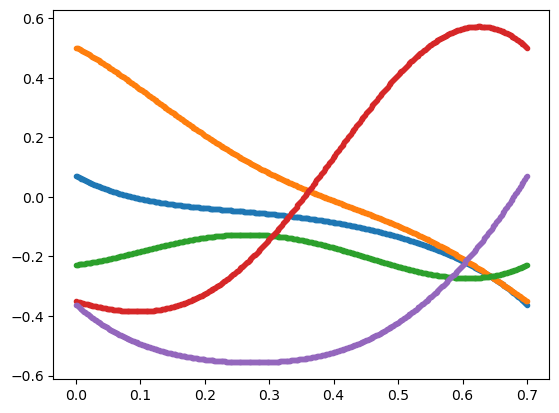

In [43]:

for ii in range(5):
    plt.plot(_t_way, _guess_arr[:,ii], c=f'C{ii}', ls = ':', marker='.')
    plt.plot(_res['t'], _res['q'][:,ii], c=f'C{ii}')


In [44]:
q_d_way = np.gradient(q_way, _t_way, axis = 0)

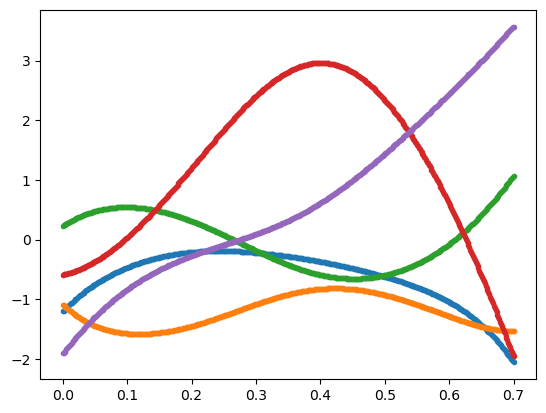

In [45]:
for ii in range(5):
    plt.plot(_t_way, q_d_way[:,ii], c=f'C{ii}', ls = ':', marker='.')
    plt.plot(_res['t'], _res['v'][:,ii], c=f'C{ii}')


In [46]:
q_d_d_way = np.gradient(q_d_way, _t_way, axis = 0)

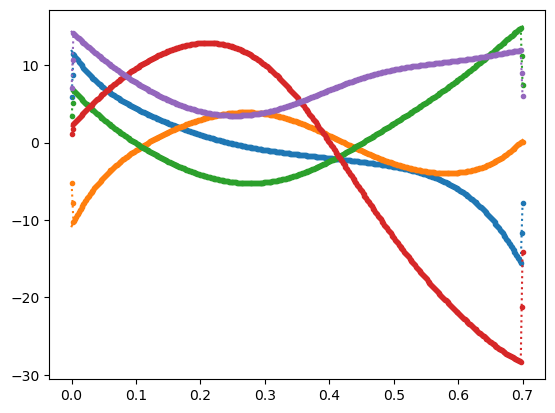

In [47]:
for ii in range(5):
    plt.plot(_t_way, q_d_d_way[:,ii], c=f'C{ii}', ls = ':', marker='.')
    plt.plot(_res['t'], _res['a'][:,ii], c=f'C{ii}')


In [48]:
_res.keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'scheme', 'n_coll', 'x', 'x_like_u', 'x_d', 'x_d_like_u', 'u', 't', 't_col', 'tau', 'tau_col', 'lam', 'u_like_x', 'q', 'q_like_u', 'v', 'v_like_u', 'a', 'a_like_u', 'interpolations'])

In [49]:
u_way = interp_2d(_t_way, _res['t'],_res['u_like_x'])
_u_guess_arr = u_way
#np.round(u_way, 6)

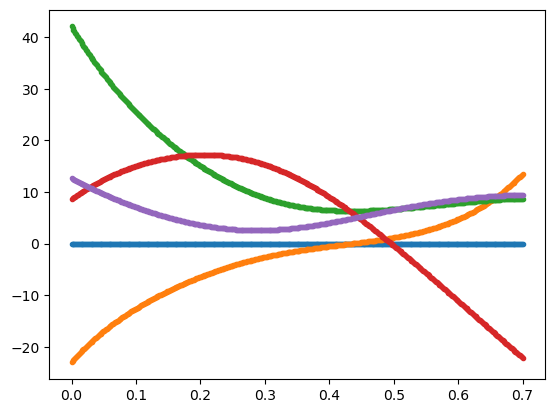

In [50]:
for ii in range(5):
    plt.plot(_t_way, u_way[:,ii], c=f'C{ii}', ls = ':', marker='.')
    plt.plot(_res['t'], _res['u_like_x'][:,ii], c=f'C{ii}')

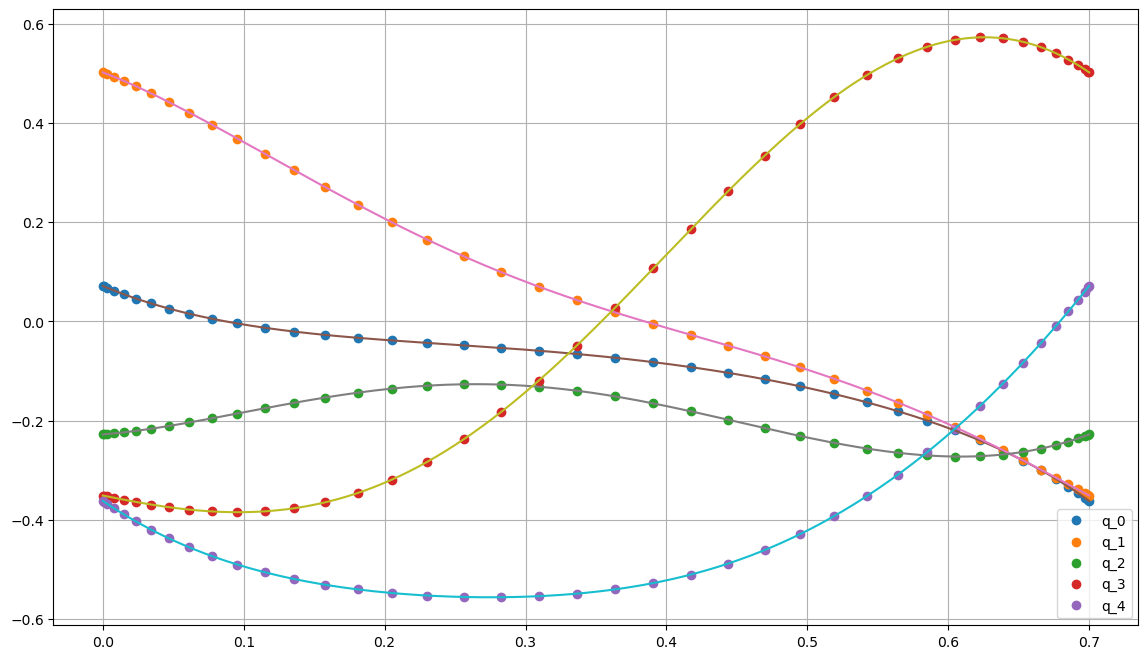

In [51]:
plt.figure(figsize=[14,8])
labels= [f'q_{ii}' for ii in range(n_q)]

for ii in range(n_q):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', ls = '', label = labels[ii])
    #plt.plot(constr_t,constr_q[:,ii], marker = 'o', ls = ':', label = labels[ii] + 'constr')
    #plt.plot(_ref['t'],_ref['q'][:,ii], marker = '', ls = '--', label = labels[ii] + ' ref')
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, q_arr)
plt.grid()
plt.legend()

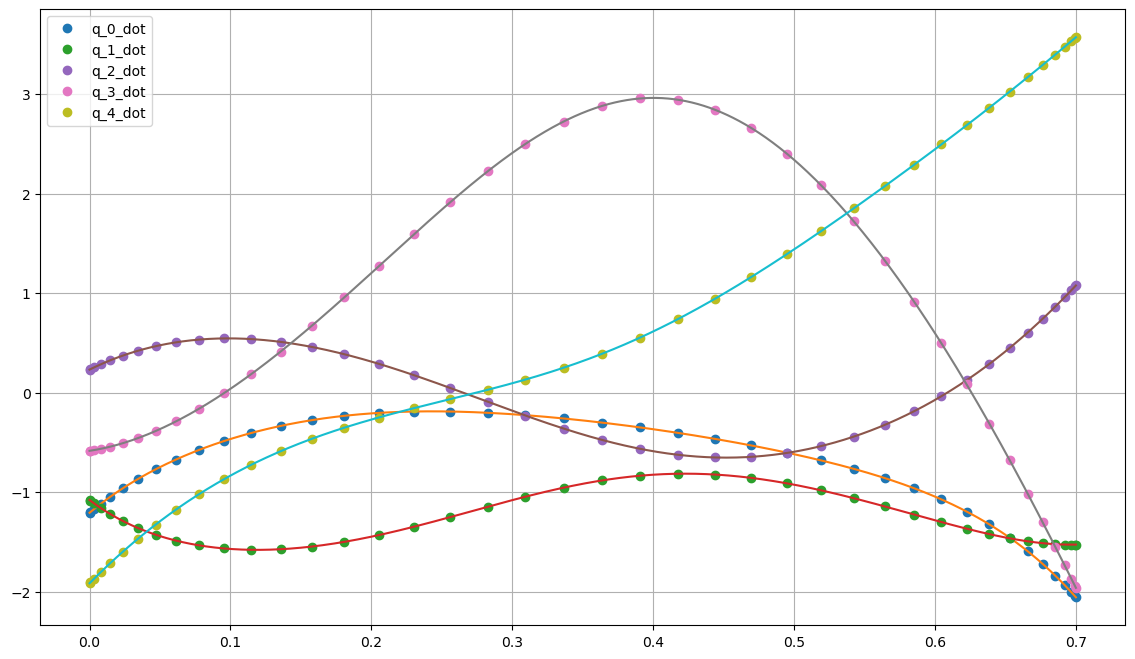

In [52]:
plt.figure(figsize=[14,8])
labels= [f'q_{ii}_dot' for ii in range(n_q)]
v_res = _res['x'][:,n_q:]
for ii in range(n_q):
    plt.plot(_res['t'],v_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    #plt.plot(_ref['t'],_ref['v'][:,ii], marker = '', ls = '--', label = labels[ii] + ' ref')
    
    #plt.plot(t_interp, v_arr[:,ii])
    plt.plot(t_interp, interpolations['q_d'][:,ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.grid()
plt.legend()

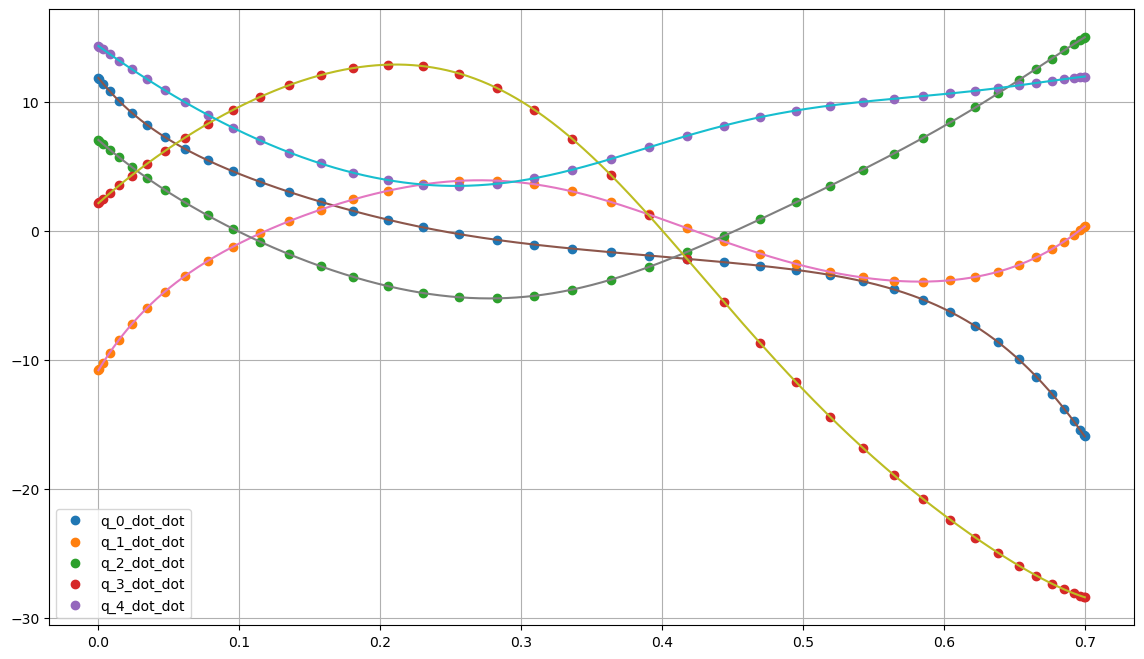

In [53]:
a_res = _res['x_d'][:,n_q:]
plt.figure(figsize=[14,8])
labels= [f'q_{ii}_dot_dot' for ii in range(n_q)]
for ii in range(n_q):
    plt.plot(_res['t'],a_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    #plt.plot(_ref['t'],_ref['a'][:,ii], marker = '', ls = '--', label = labels[ii] + ' ref')
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['a_c'][:,ii], 'o', label = labels[ii] + '_c')
#plt.plot(t_interp, a_arr)
plt.plot(t_interp, interpolations['q_d_d'])
plt.grid()
plt.legend()

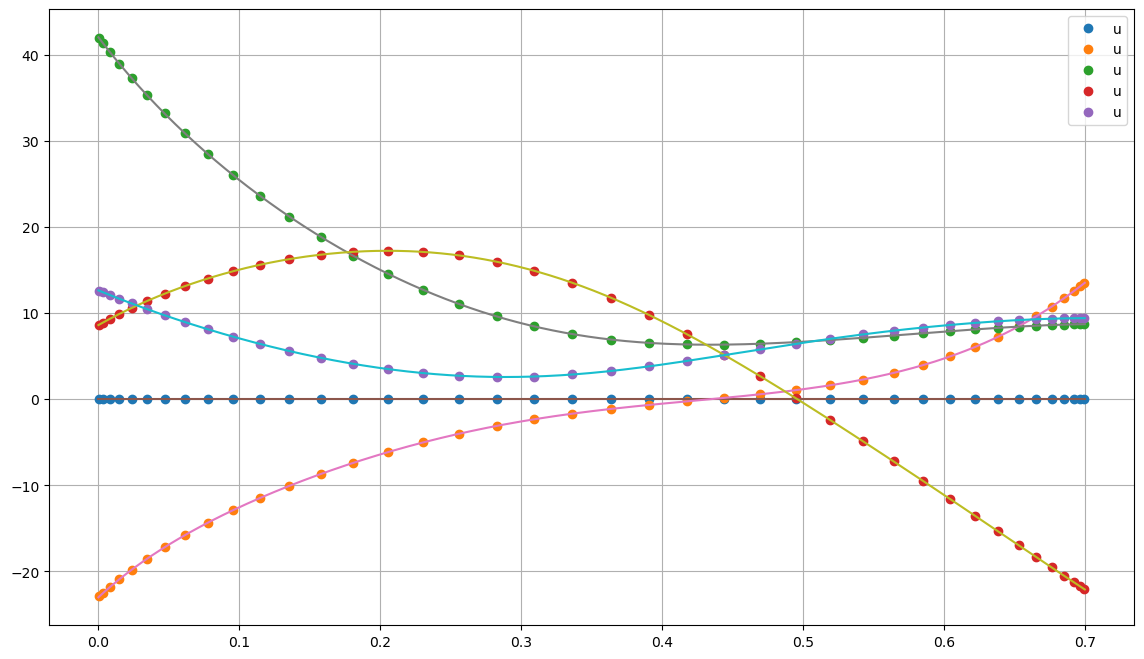

In [54]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], marker = 'o', ls = '', label = 'u')
#plt.plot(_ref['t_col'],_ref['u'][:], marker = '', ls = '--', label = labels[ii] + ' ref')
plt.plot(t_interp, u_arr)
if 'parab' in _res['scheme']:
    plt.plot(_res['t_c'],_res['u_c'][:], 'o', label = 'u_c')
plt.grid()
plt.legend()

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [55]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [56]:
schemes = [
    #'LG2',
    'hs_parab',
    'trapz',
    'hs_mod_parab',
    'trapz_mod',
    'hsn_parab',
    'trapz_n',
    'LG',
    'LGR',
    'LGL',
    #'CG',
    #'BU_LG',
    #'BU_LGR',
    #'BU_LGL',
    #'BU_CG',
    #'TD_LG',
    #'TD_LGR',
    #'TD_LGL',
    #'TD_CG',
] #If you defined a custom function, name your scheme here
initial = 'waypoints' #'lin'
solve_repetitions = 3 #Increase this number to get more reliable values of execution times
N_arr = [
    5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50,# 55, 60, 75,
    #80, 90, 100,
    #110, 120, 125, 130, 140, 150, 160, 170, 175, 180, 190, 200, 220, 225, 240, 250, 260, 275,
    #280, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600
]# You can increase the numbers here, but it will take more time
#N_arr = [50, 60,]

recalculate = True


# -----------------------

if recalculate:
    results = {}

for scheme in schemes:
        for order in range(1,3):
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR','hs_parab','trapz',] and order != 1:
                continue
            key = scheme + f'_{order}'
            if recalculate:
                results[key] = {'N_arr':N_arr}
                results[key]['scheme'] = scheme
                results[key]['order'] = order
            else:
                for element in N_arr:
                    if element not in results[key]['N_arr']:
                        results[key]['N_arr'].append(element)
                results[key]['N_arr'].sort()
            
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        for order in range(1,3):
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR','hs_parab','trapz',] and order != 1:
                continue
            key = scheme + f'_{order}'
            print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            if recalculate or N not in results[key].keys():
                try:
                    results[key][N] = five_link(
                    scheme,
                    N, 
                    initial,
                    solve_repetitions=solve_repetitions,
                    order = order,
                    silent=True, 
                    verbose=False)
                except RuntimeError: 
                    results[key][N] = None
                    print('ATTEMPT FAILED!!')
                    results[key][N] = copy(five_link(
                        scheme,
                        20, 
                        initial,
                        solve_repetitions=solve_repetitions,
                        order = 2,
                        silent=True, 
                        verbose=False))
                    for item in results[key][N]:
                        try:
                            results[key][N][item] = results[key][N][item]*np.nan
                        except TypeError:
                            results[key][N][item] = np.nan
        


	N = 5
Problem: hs_parab_1,  22:01:05 
Problem: trapz_1,  22:01:05 
Problem: hs_mod_parab_1,  22:01:05 
ATTEMPT FAILED!!
Problem: hs_mod_parab_2,  22:01:06 
Problem: trapz_mod_1,  22:01:06 
ATTEMPT FAILED!!
Problem: trapz_mod_2,  22:01:07 
Problem: hsn_parab_1,  22:01:07 
Problem: hsn_parab_2,  22:01:07 
Problem: trapz_n_1,  22:01:07 
Problem: trapz_n_2,  22:01:07 
Problem: LG_1,  22:01:07 
Problem: LGR_1,  22:01:08 
Problem: LGL_1,  22:01:08 
	N = 7
Problem: hs_parab_1,  22:01:08 
Problem: trapz_1,  22:01:09 
Problem: hs_mod_parab_1,  22:01:09 
ATTEMPT FAILED!!
Problem: hs_mod_parab_2,  22:01:09 
Problem: trapz_mod_1,  22:01:09 
ATTEMPT FAILED!!
Problem: trapz_mod_2,  22:01:09 
Problem: hsn_parab_1,  22:01:09 
Problem: hsn_parab_2,  22:01:09 
Problem: trapz_n_1,  22:01:10 
Problem: trapz_n_2,  22:01:10 
Problem: LG_1,  22:01:10 
Problem: LGR_1,  22:01:10 
Problem: LGL_1,  22:01:11 
	N = 10
Problem: hs_parab_1,  22:01:11 
Problem: trapz_1,  22:01:11 
Problem: hs_mod_parab_1,  22:01:12 

In [57]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)

Text(0.5, 1.0, 'Final traj cost')

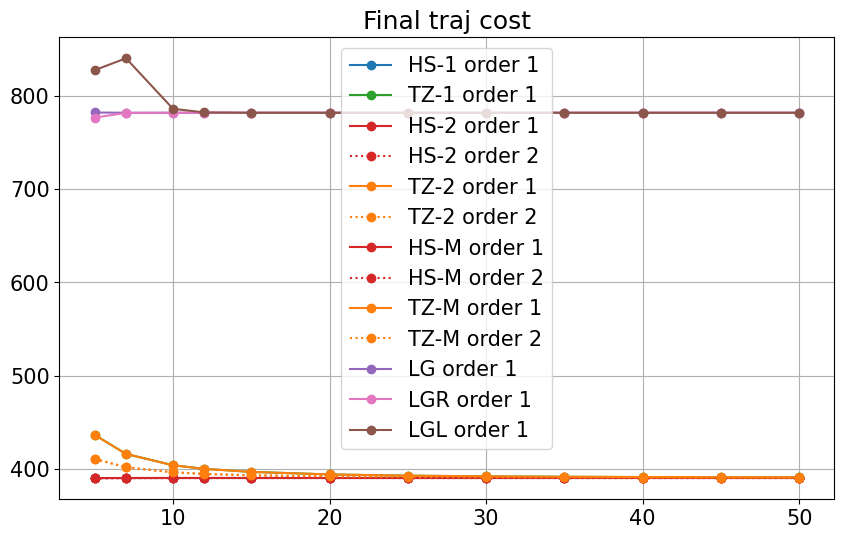

In [58]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [59]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

from chords.td_pseudospectral import dynamic_error_TD, interpolations_deriv_TD_pseudospectral

In [60]:
from chords.analysis import dynamic_errors

In [61]:
results.keys()

dict_keys(['hs_parab_1', 'trapz_1', 'hs_mod_parab_1', 'hs_mod_parab_2', 'trapz_mod_1', 'trapz_mod_2', 'hsn_parab_1', 'hsn_parab_2', 'trapz_n_1', 'trapz_n_2', 'LG_1', 'LGR_1', 'LGL_1'])

In [62]:
n_interp = 2000
for ii, key in enumerate(results.keys()):
    scheme = results[key]['scheme'] 
    print('Problem:', key, f' {ii+1} of {len(results.keys())} - ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            nan_arr = np.zeros([n_interp, n_q])*np.nan
            errors= {
                'compat_err_1_interp': nan_arr,
                'dyn_err_interp' : nan_arr,
            }
            res['error'] = errors
        else:
            if 'error' not in res.keys():
                errors = dynamic_errors(
                    res,
                    F_nump,
                    dynamics_error_mode = 'q',
                    problem_order=2,
                    scheme_order=2,
                    x_interp=None,
                    u_interp=None,
                    n_interp=n_interp,
                )
            #res['error'] = errors
        dyn_err_q = errors['compat_err_1_interp']
        dyn_err_2 = errors['dyn_err_interp']
        t_arr = np.linspace(0,0.7, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        errors['err_q'] = tot_dyn_err_q
        errors['err_2'] = tot_dyn_err_2
            

Problem: hs_parab_1  1 of 13 -  22:02:56 
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: trapz_1  2 of 13 -  22:03:08 
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: hs_mod_parab_1  3 of 13 -  22:03:19 
	N = 5
		NaN in Scheme
	N = 7
		NaN in Scheme
	N = 10
		NaN in Scheme
	N = 12
		NaN in Scheme
	N = 15
		NaN in Scheme
	N = 20
		NaN in Scheme
	N = 25
		NaN in Scheme
	N = 30
		NaN in Scheme
	N = 35
		NaN in Scheme
	N = 40
		NaN in Scheme
	N = 45
		NaN in Scheme
	N = 50
		NaN in Scheme
Problem: hs_mod_parab_2  4 of 13 -  22:03:19 
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
	N = 30
	N = 35
	N = 40
	N = 45
	N = 50
Problem: trapz_mod_1  5 of 13 -  22:03:32 
	N = 5
		NaN in Scheme
	N = 7
		NaN in Scheme
	N = 10
		NaN in Scheme
	N = 12
		NaN in Scheme
	N = 15
		NaN in Scheme
	N = 20
		NaN in Scheme
	N = 25
		NaN in Scheme
	N = 30
		NaN in Scheme
	N = 35
		NaN in Scheme
	N

In [63]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [64]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        errors['err_compat_tot'] = np.sum(np.abs(errors['compat_err_1_interp']), axis = 1)
        errors['err_2_tot'] = np.sum(np.abs(errors["dyn_err_interp"]), axis = 1)
        err_q_acum.append(np.sum(errors['err_q']))
        err_2_acum.append(np.sum(errors['err_2']))
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

Problem: hs_parab_1
Problem: trapz_1
Problem: hs_mod_parab_1
Problem: hs_mod_parab_2
Problem: trapz_mod_1
Problem: trapz_mod_2
Problem: hsn_parab_1
Problem: hsn_parab_2
Problem: trapz_n_1
Problem: trapz_n_2
Problem: LG_1
Problem: LGR_1
Problem: LGL_1


for key in results.keys():
    scheme = results[key]['scheme']
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
            
        _derivs = interpolations_deriv_TD_pseudospectral(
            _case['q_constr'],
            _case['x'],
            _case['x_d'],
            scheme,
            deriv_order = 1,
            t0 = 0,
            tf = _case['t'][-1],
            n_coll=_case['u'].shape[0],
            scheme_order = 2,
            x_interp="pol",
            n_interp=n_interp,
        )
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [65]:
from chords.util import plot_by_segments, save_fig
from chords.opti import _implemented_equispaced_schemes

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [66]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'scheme', 'n_coll', 'x', 'x_node', 'x_like_u', 'x_d', 'x_d_node', 'x_d_like_u', 'u', 't', 't_node', 't_col', 'tau', 'tau_node', 'tau_col', 'lam', 'u_like_x', 'q', 'q_node', 'q_like_u', 'v', 'v_node', 'v_like_u', 'interpolations', 'error'])

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [67]:
results[key][N]['error'].keys()

dict_keys(['dyn_err_interp', 'compat_err_1_interp', 'err_q', 'err_2', 'err_compat_tot', 'err_2_tot'])

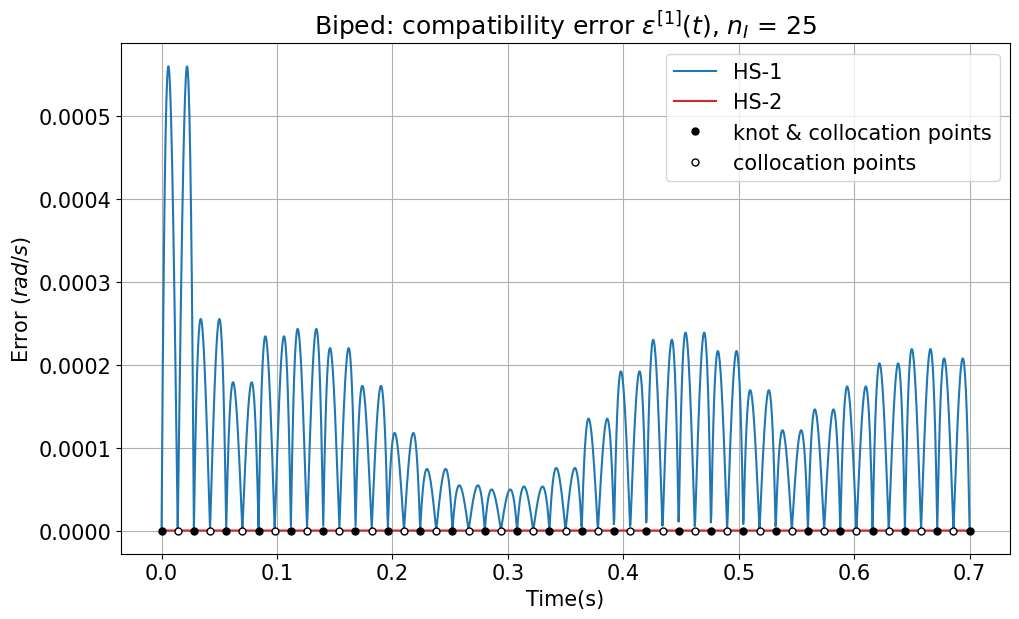

In [71]:
#plot_schemes = ['trapz', 'trapz_mod']
plot_schemes = ['hs_parab', 'hs_mod_parab']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
#N = 50
N = 25
save = True

plt.figure(figsize=oct_fig_size)
    
for key in results.keys():
    scheme = results[key]['scheme']
    if scheme not in plot_schemes:
        continue
    if 'mod' in scheme and results[key]['order'] == 1:
        continue
    if scheme in _implemented_equispaced_schemes:
        N_name = '$n_I$'
    else:
        N_name = '$N$'
        plot_kw = scheme_kwargs(scheme, longlabel=False)
    t_arr = np.linspace(
        0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
    )
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    #plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']#+' order '+str(results[key]['order'])
    plot_kw['marker'] = ''
    plt.plot(t_arr, results[key][N]['error']['err_compat_tot'], **plot_kw)
    last_key = key
    #plt.plot(t_arr, results[key][N]['error']['err_2_tot'], **plot_kw)
plt.plot(
    results[last_key][N]["t"],
    np.zeros(len(results[last_key][N]["t"])),
    "ok",
    ms=5,
    label="knot & collocation points",
)
if 'hs' in plot_schemes[0]:
    plt.plot(results[last_key][N]['t_c'], 
                 np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                 label = 'collocation points')
plt.legend()
plt.grid()
plt.title(r'Biped: compatibility error $\varepsilon^{[1]}(t)$, '+f'{N_name} = {N}')
plt.xlabel("Time(s)")
plt.ylabel(ylabels[1])
plt.tight_layout(pad=0.0)
if save:
    save_fig(
            problem_name = problem_name,
            graph_name = 'first_order_dyn_error',
            schemes_printed = plot_schemes,
            save_format = 'pdf',
            N = N,
            q_counter = 1,
        )

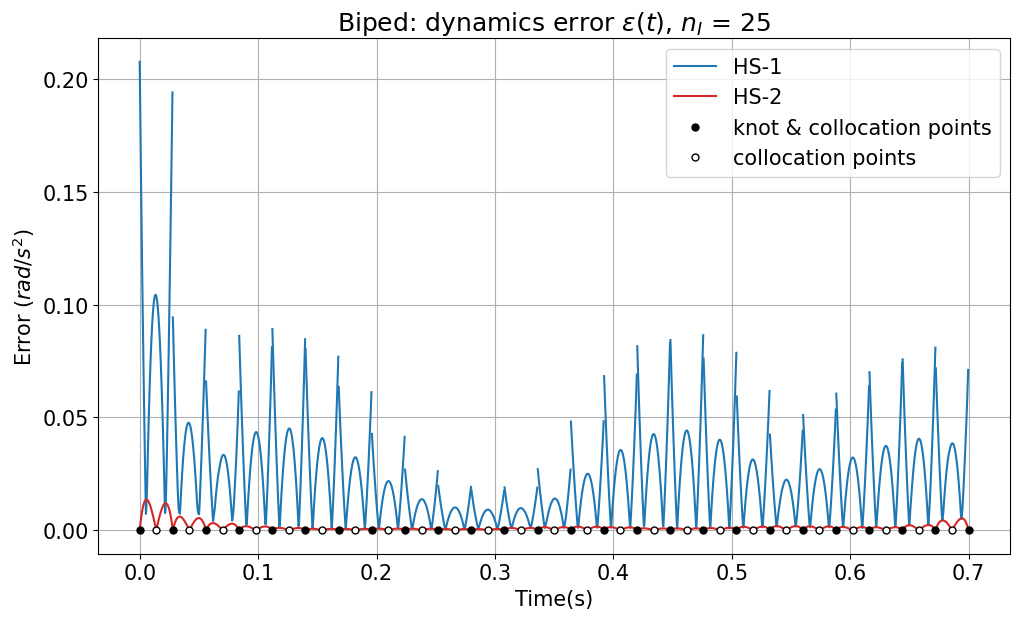

In [73]:
ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']

plt.figure(figsize=oct_fig_size)

for key in results.keys():
    scheme = results[key]['scheme']
    if scheme not in plot_schemes:
        continue
    if 'mod' in scheme and results[key]['order'] == 1:
        continue
    if scheme in _implemented_equispaced_schemes:
        N_name = '$n_I$'
    else:
        N_name = '$N$'
    t_arr = np.linspace(
        0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
    )
    plot_kw = scheme_kwargs(scheme, longlabel=False)
   # plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    label = plot_kw['label'] #= plot_kw['label']+' order '+str(results[key]['order'])
    del(plot_kw['label'])
    plot_kw['marker'] = ''
    plot_by_segments(
            t_arr,
            y_plot = results[key][N]['error']['err_2_tot'],
            label = label,
            N = N,
            end_t = t_arr[-1],
            plot_dict = plot_kw)
    last_key = key
    #plt.plot(t_arr, results[key][N]['error']['err_2_tot'], **plot_kw)
plt.plot(
    results[last_key][N]["t"],
    np.zeros(len(results[last_key][N]["t"])),
    "ok",
    ms=5,
    label="knot & collocation points",
)
if 'hs' in plot_schemes[0]:
    plt.plot(results[last_key][N]['t_c'], 
                 np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                 label = 'collocation points')
plt.legend()
plt.grid()
plt.title(r'Biped: dynamics error $\varepsilon(t)$, '+f'{N_name} = {N}')
plt.xlabel("Time(s)")
plt.ylabel(ylabels[1])
plt.tight_layout(pad=0.0)
if save:
    save_fig(
            problem_name = problem_name,
            graph_name = 'second_order_dyn_error',
            schemes_printed = plot_schemes,
            save_format = 'pdf',
            N = N,
            q_counter = 1,
        )

In [74]:
results.keys()

dict_keys(['hs_parab_1', 'trapz_1', 'hs_mod_parab_1', 'hs_mod_parab_2', 'trapz_mod_1', 'trapz_mod_2', 'hsn_parab_1', 'hsn_parab_2', 'trapz_n_1', 'trapz_n_2', 'LG_1', 'LGR_1', 'LGL_1'])

In [75]:
from chords.util import save_fig

In [76]:
import chords
import importlib
importlib.reload(chords.piecewise)
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.analysis)
importlib.reload(chords.opti)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab, scheme_kwargs

In [77]:
def plot_err_dyn(schemes, markersize = 10, title = None):
    data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
    data_key = data_array[2]
    for qq in range(1):
        plt.figure(figsize=oct_fig_size)
        if title is None:
            plt.title(r'Bipedal walking: integral dynamics error $\int\varepsilon$')#_{q_'+f'{qq+1}}}
        else:
            plt.title(title)
        for key in schemes: #results.keys():#
            scheme = results[key]['scheme']
            plot_kw = scheme_kwargs(scheme, longlabel=False)
            plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
            if order_in_legend:
                plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
            plot_kw['ms'] = markersize
            if 'TD' in scheme:
                plot_kw['marker'] = 'x'
                plot_kw['mew'] = '2'

            if 'BU' in scheme:
                plot_kw['marker'] = '+'
                plot_kw['mew'] = '2'
            N_arr = results[key]['N_arr']
            if len(results[key][data_key].shape) == 1:
                plt.plot(N_arr,
                 results[key][data_key],
                 **plot_kw)
            else:
                plt.plot(N_arr,
                 results[key][data_key][:,qq],
                 **plot_kw)
        plt.yscale('log')
        ticks = np.array(results[key]['N_arr'])
        #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
        plt.xticks(ticks, labels=ticks)
        plt.xlabel('Number of colocation points')
        plt.grid()
        plt.legend()#loc = 'lower left'
        units = 'rad/s'

        if fixed_y_scale:
            y_lims = [2e-12, 8]
            plt.ylim(y_lims)

        plt.ylabel(f'Dynamics error $({units})$')
        plt.tight_layout(pad = 0.0)
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        if save:
            save_fig(
                problem_name = problem_name,
                graph_name = 'integ_dyn_error',
                schemes_printed = schemes,
                save_format = save_fmt,
                N = None,
                q_counter = None,
            )

In [78]:
def plot_t_n(schemes, markersize = 10, title = None):
    plt.figure(figsize=[10,6])
    for key in schemes:#results.keys():
        scheme = results[key]['scheme']
        #if "C" not in scheme:
                #continue
                #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['ms'] = markersize
        if 'TD' in scheme:
            plot_kw['marker'] = 'x'
            plot_kw['mew'] = '2'
        if 'BU' in scheme:
            plot_kw['marker'] = '+'
            plot_kw['mew'] = '2'

        plt.plot(results[key]['N_arr'],
                 results[key][f'cpudt'],
                 **plot_kw
                )
    if fixed_y_scale:
        y_lims = [0.02, 4]
        plt.ylim(y_lims)
    plt.grid()
    plt.legend()
    if title is None:
        plt.title('Bipedal walking: optimization time')
    else:
        plt.title(title)
    
    plt.xlabel('Number of collocation points')
    plt.ylabel('Time (s)')
    plt.yscale('log')
    plt.xscale('log')
    plt.tight_layout(pad = 0.0)
    ticks = np.array(results[key]['N_arr'])
    #ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
    #ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
    plt.xticks(ticks, labels=ticks)
    _ = []
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'opt_time',
            schemes_printed = schemes,
            save_format = save_fmt,
            N = None,
            q_counter = None,
        )

In [79]:
markersize = 10
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    #'hsn_parab_2',
    #'trapz_n_1',
    #'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
]

In [80]:
save = True#False#
save_fmt = 'pdf'
fixed_y_scale = True

In [81]:
schemes_list = [
    ['LG_1','BU_LG_1','TD_LG_1',],
    ['BU_LG_1','BU_LG_2','TD_LG_1','TD_LG_2',],
    ['LG_1','BU_LG_1','BU_LG_2','TD_LG_1','TD_LG_2',],
    ['LGR_1','BU_LGR_1','TD_LGR_1',],
    ['BU_LGR_1','BU_LGR_2','TD_LGR_1','TD_LGR_2',],
    ['LGR_1','BU_LGR_1','BU_LGR_2','TD_LGR_1','TD_LGR_2',],
    ['LGL_1','BU_LGL_1','TD_LGL_1',],
    ['BU_LGL_1','BU_LGL_2','TD_LGL_1','TD_LGL_2',],
    ['LGL_1','BU_LGL_1','BU_LGL_2','TD_LGL_1','TD_LGL_2',],
    ['LG_1','LGR_1','LGL_1','BU_LG_1','BU_LG_2','BU_LGR_1','BU_LGR_2','BU_LGL_1',
    'BU_LGL_2','TD_LG_1','TD_LG_2','TD_LGR_1','TD_LGR_2','TD_LGL_1','TD_LGL_2',]
]
schemes_alias = [
    'LG',
    'LG',
    'LG',
    'LGR',
    'LGR',
    'LGR',
    'LGL',
    'LGL',
    'LGL',
    'All'
    
]

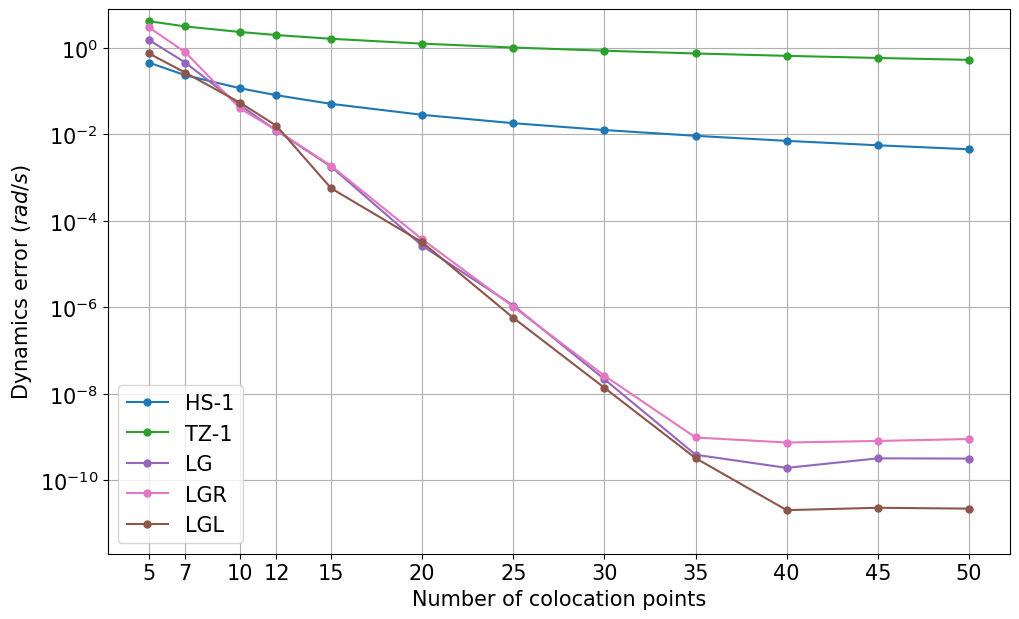

In [83]:
order_in_legend = False
plot_err_dyn(
    ['hs_parab_1','trapz_1','LG_1','LGR_1','LGL_1',],
    markersize = 5, title='')

In [78]:
order_in_legend = True

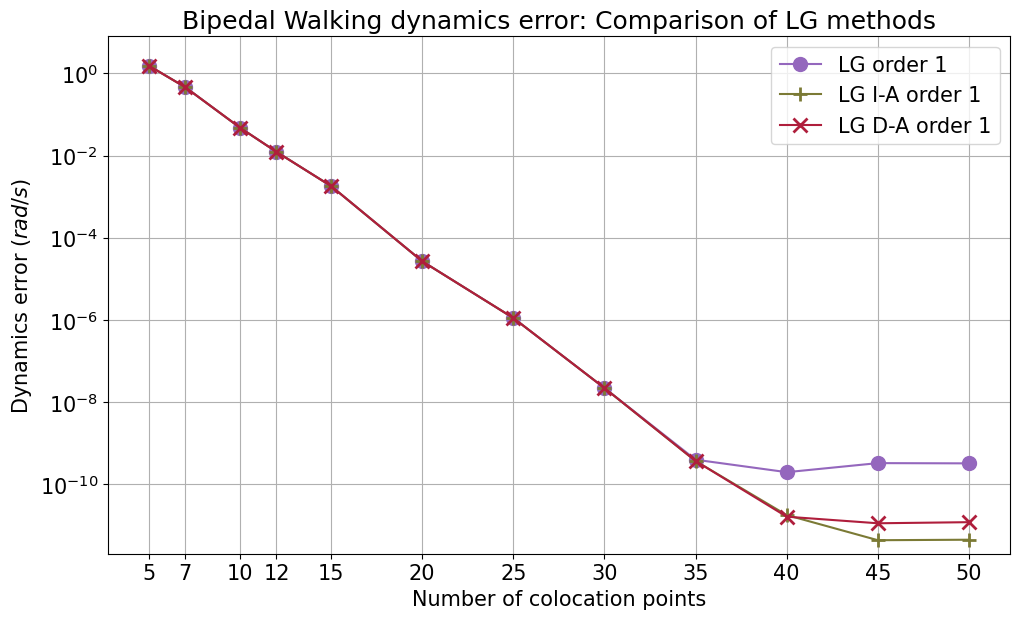

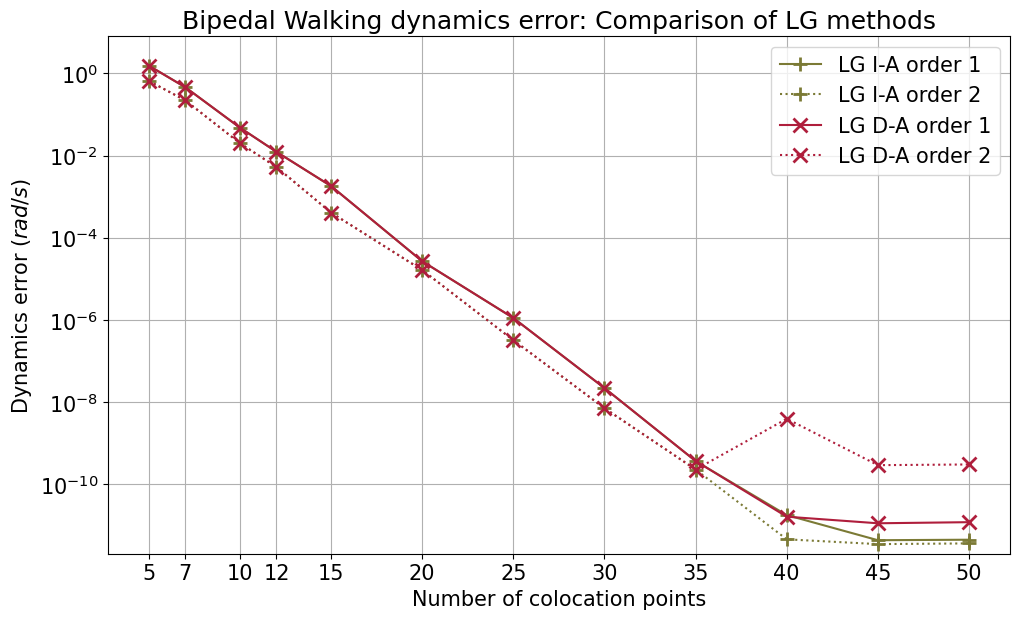

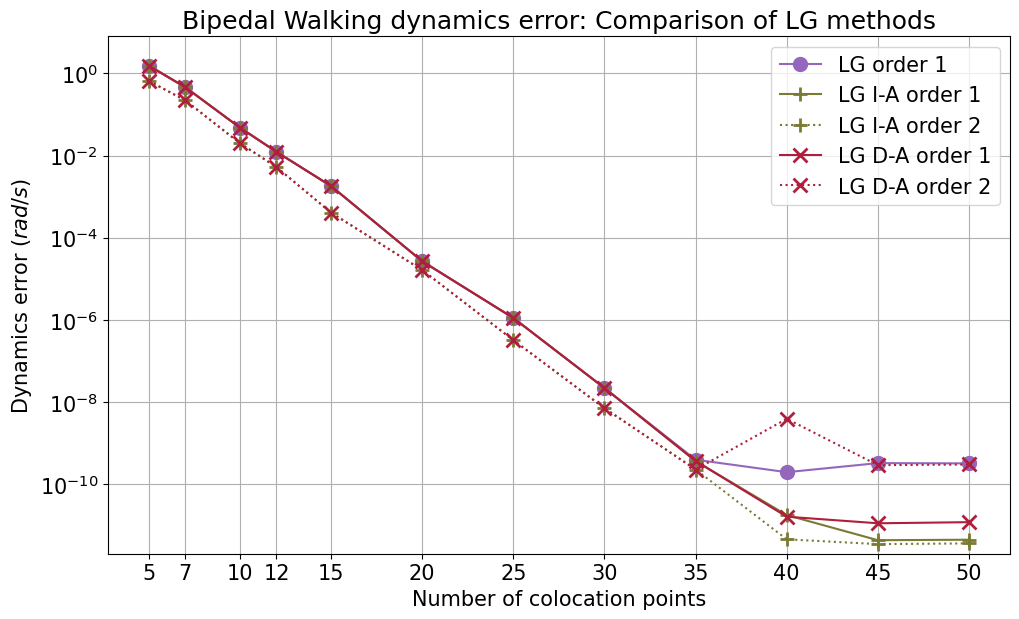

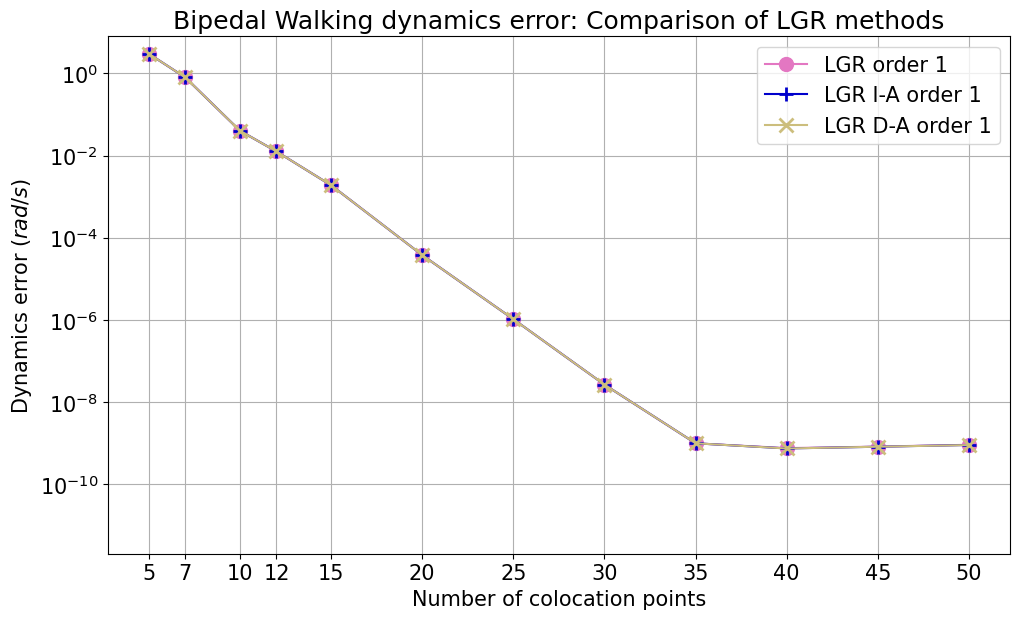

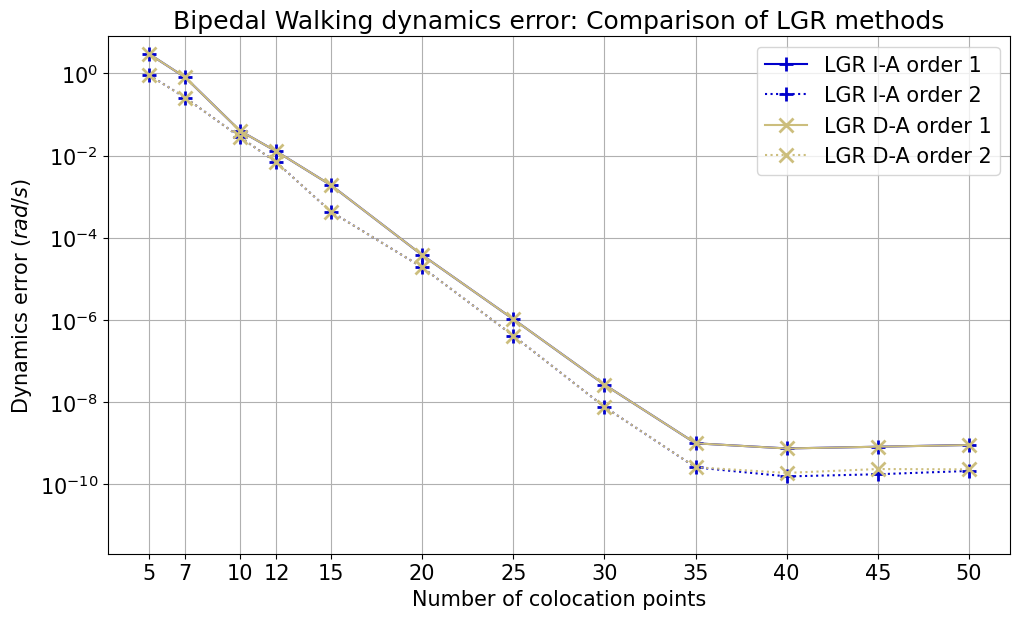

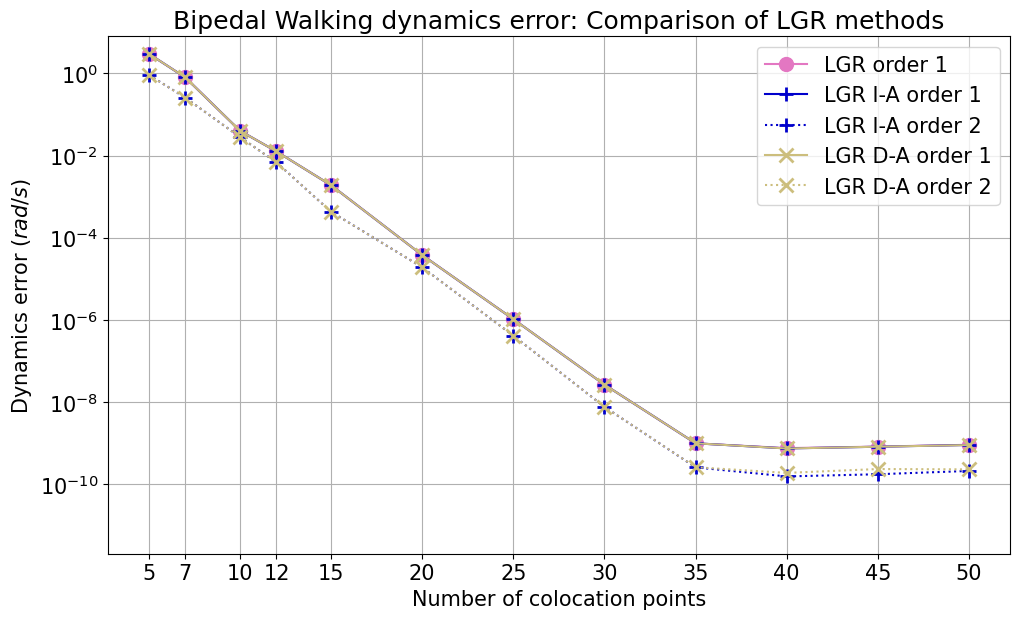

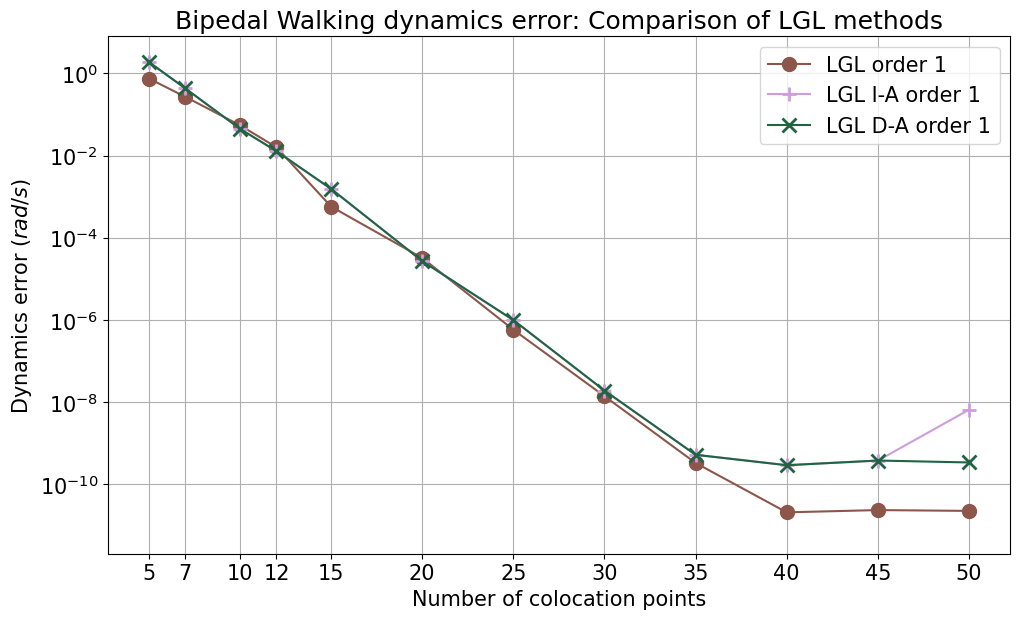

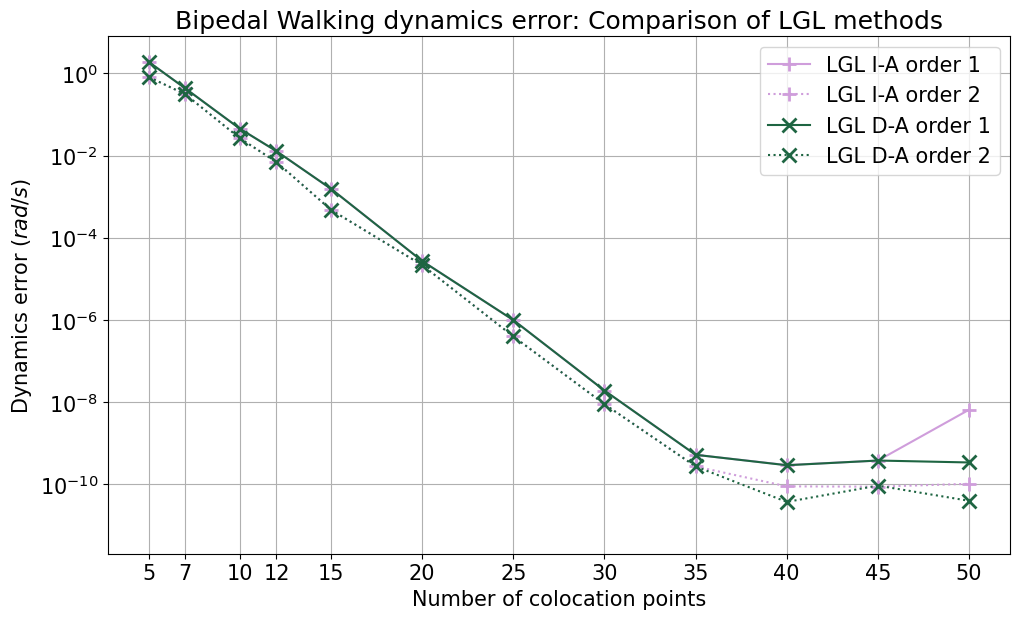

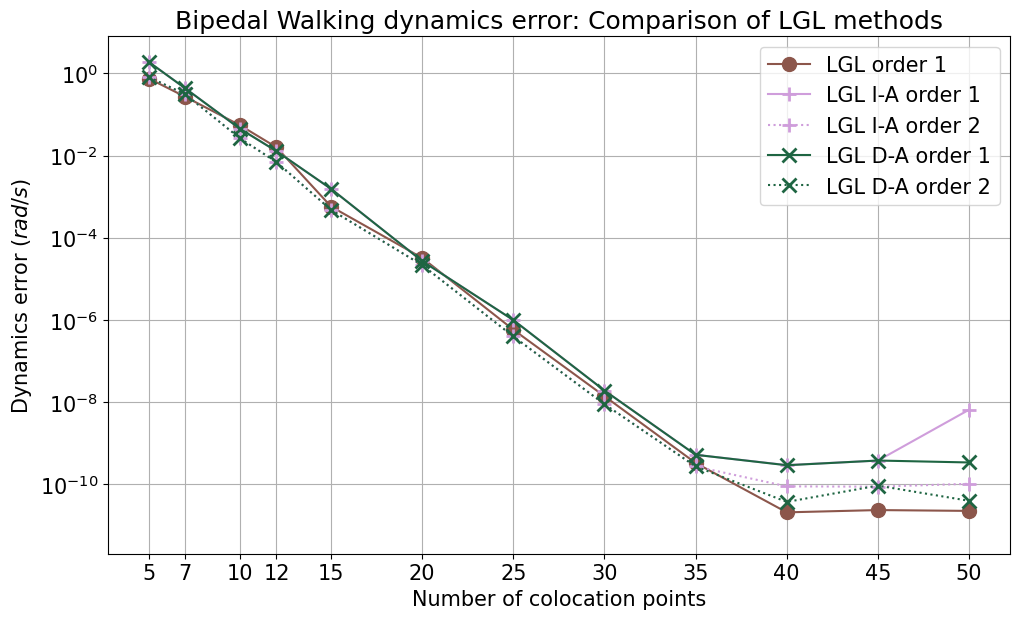

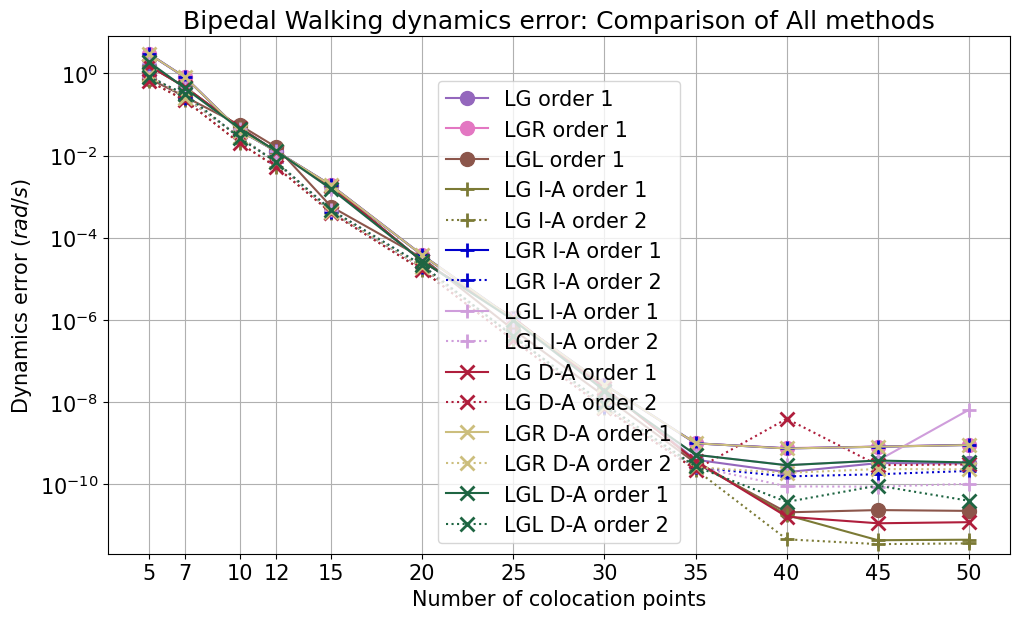

In [99]:
for jj,schemes in enumerate(schemes_list):
    sch_name = schemes_alias[jj]
    title = f'Bipedal Walking dynamics error: Comparison of {sch_name} methods'
    plot_err_dyn(schemes, title=title)

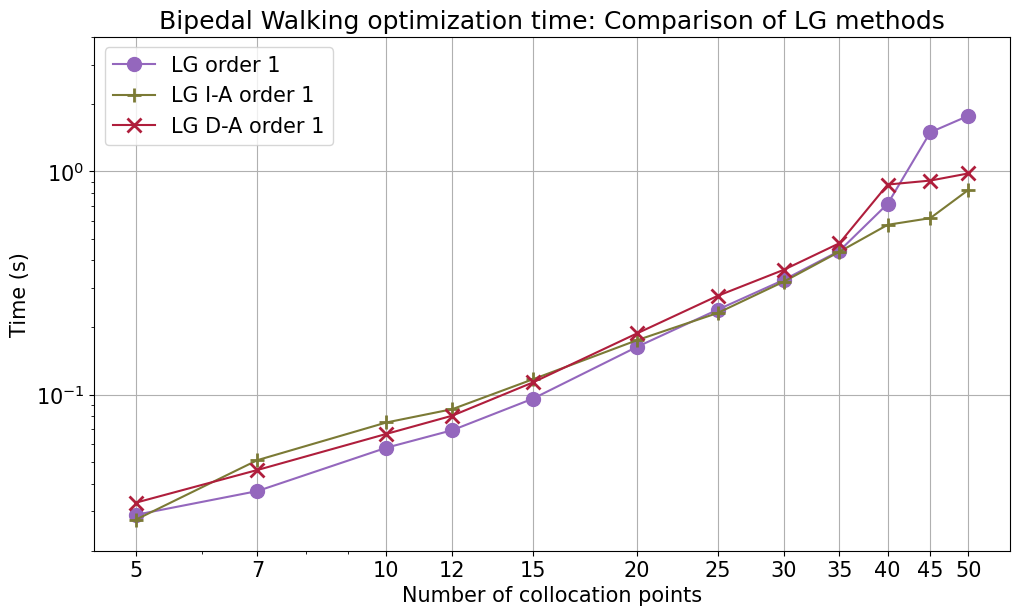

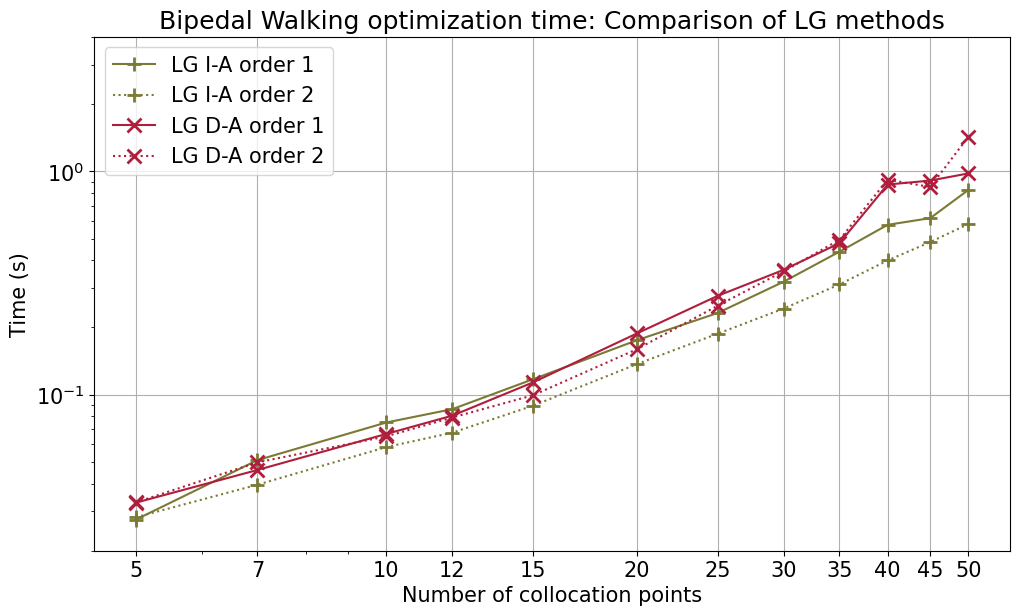

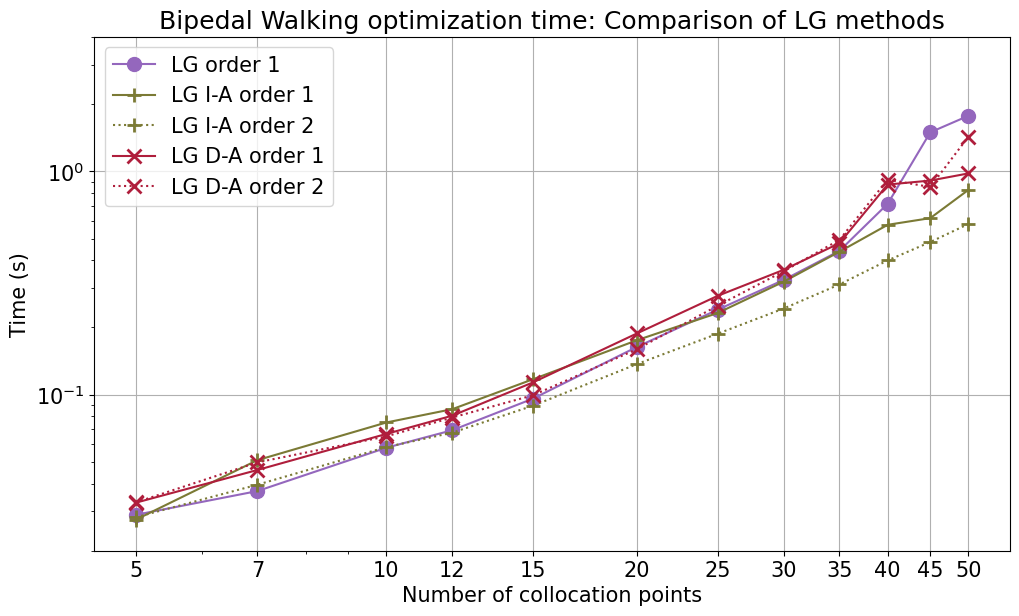

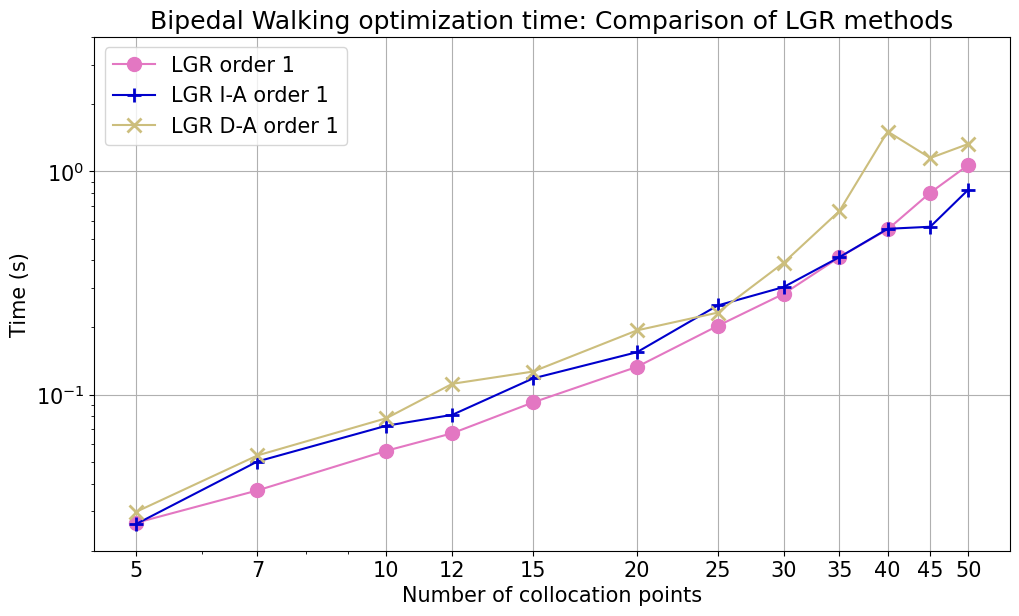

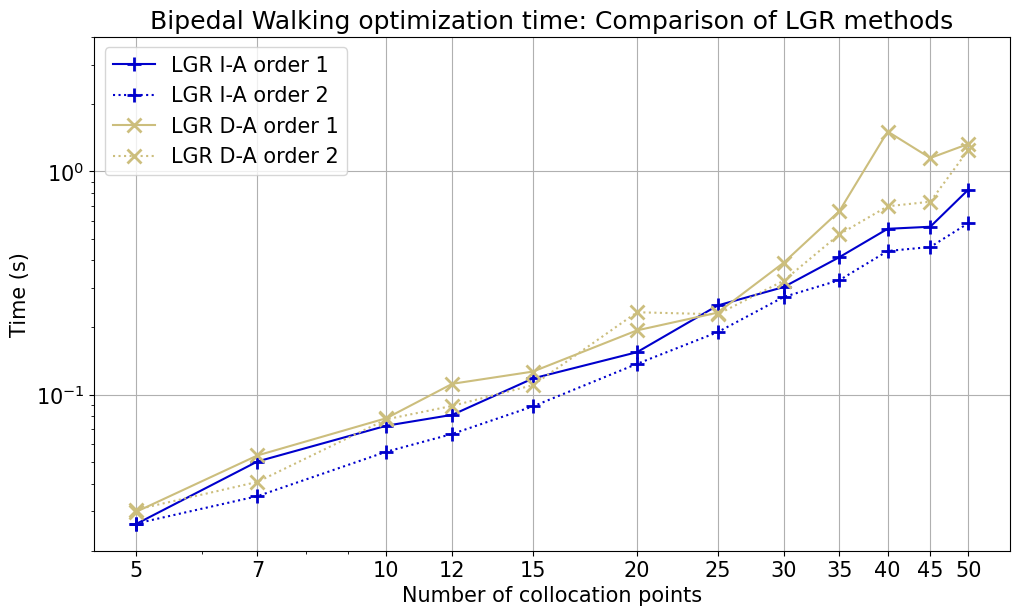

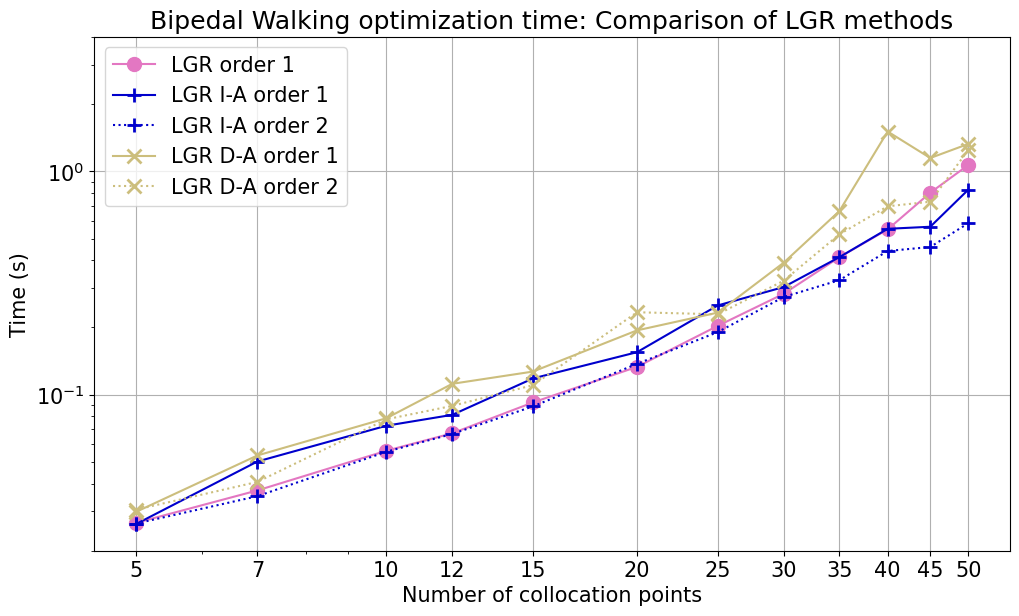

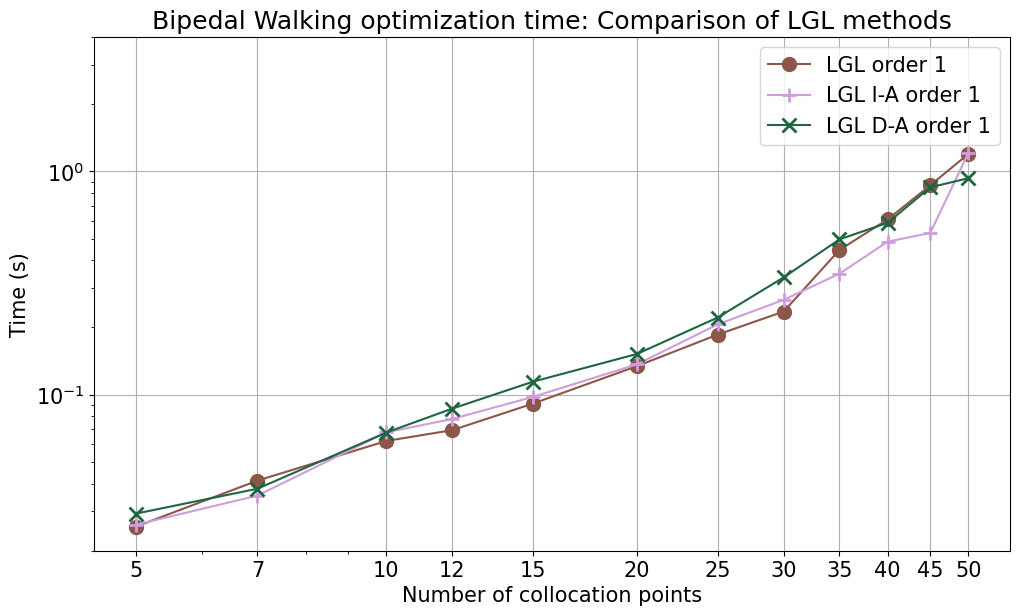

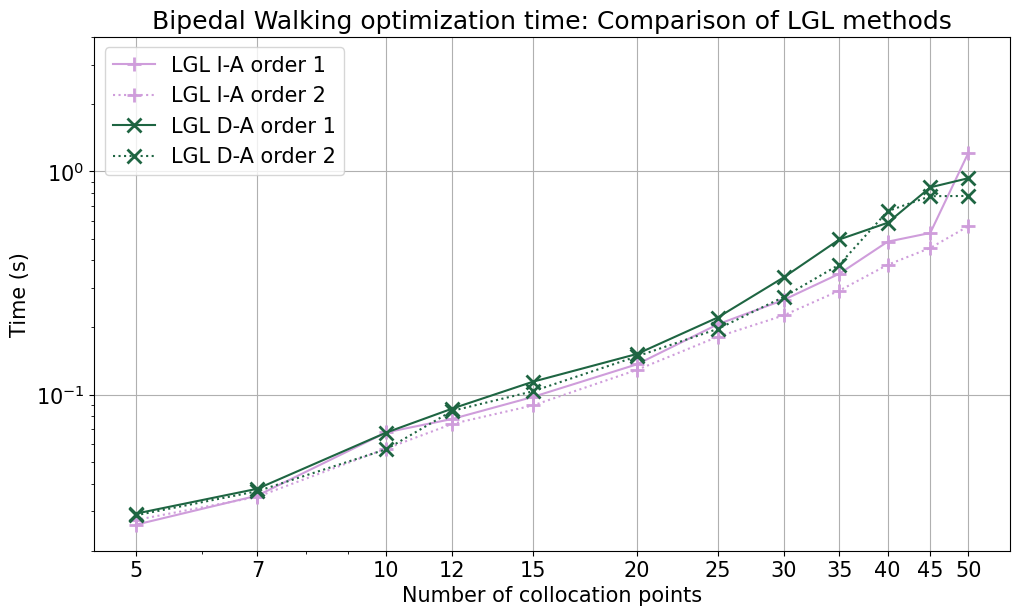

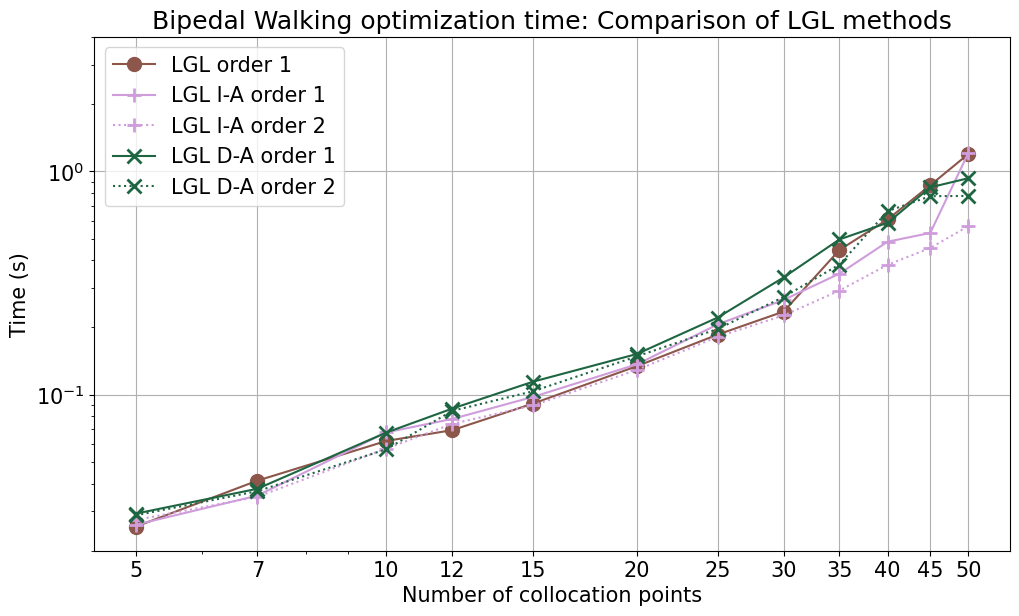

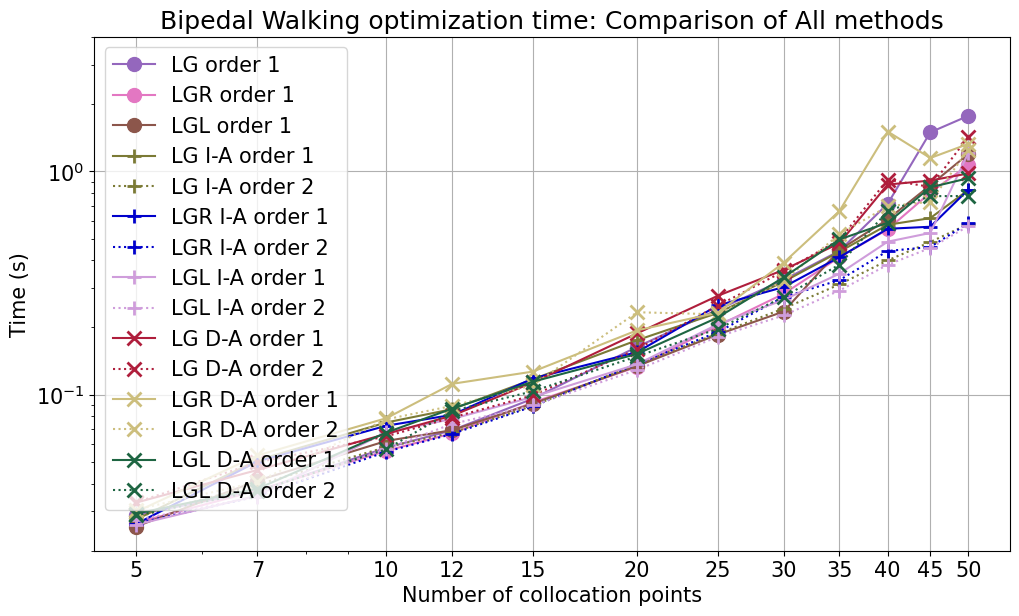

In [100]:
for jj,schemes in enumerate(schemes_list):
    sch_name = schemes_alias[jj]
    title = f'Bipedal Walking optimization time: Comparison of {sch_name} methods'
    plot_t_n(schemes, title=title)

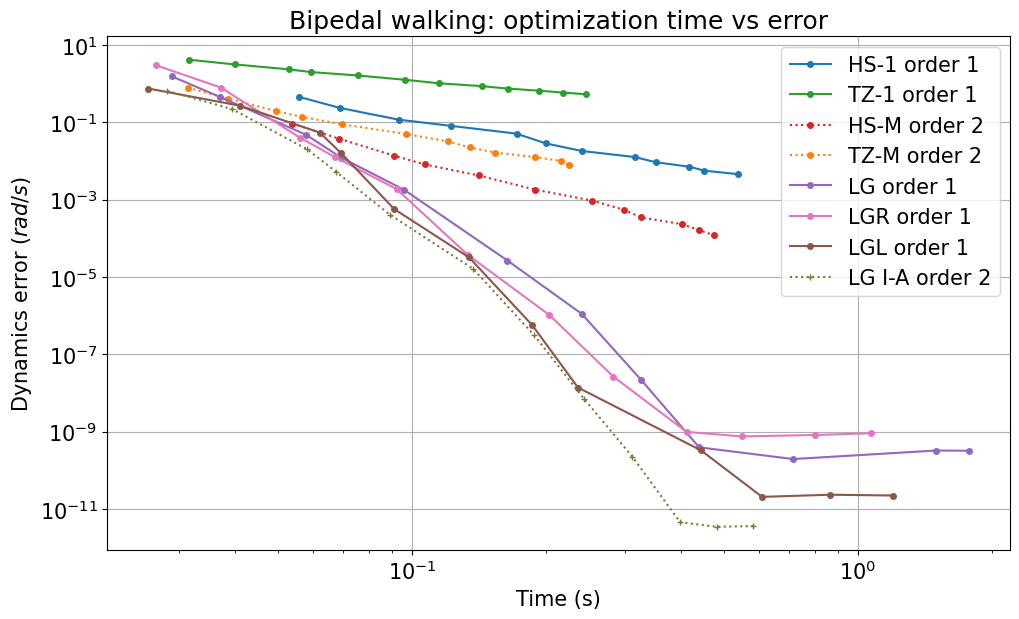

In [81]:
plt.figure(figsize=[10,6])
for key in [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    'hsn_parab_2',
    #'trapz_n_1',
    'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
]:#results.keys():
    
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plot_kw['ms'] = 4
    if 'TD' in scheme:
         plot_kw['marker'] = 'x'
    if 'BU' in scheme:
         plot_kw['marker'] = '+'
    plt.plot(
        #results[key]['N_arr'],
             results[key][f'cpudt'],
             results[key]['err_2_acum'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Bipedal walking: optimization time vs error')
plt.xlabel('Time (s)')
plt.ylabel(f'Dynamics error $(rad/s)$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
#plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_vs_error',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [82]:
markersize = 5
schemes = ['BU_LG',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
]

In [83]:
markersize = 5
schemes = ['BU_LG',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
]

In [84]:
markersize = 5
schemes = ['BU_LG','TD_LG','BU_LGR','TD_LGR','BU_LGL','TD_LGL',]

In [85]:
q_arr = []

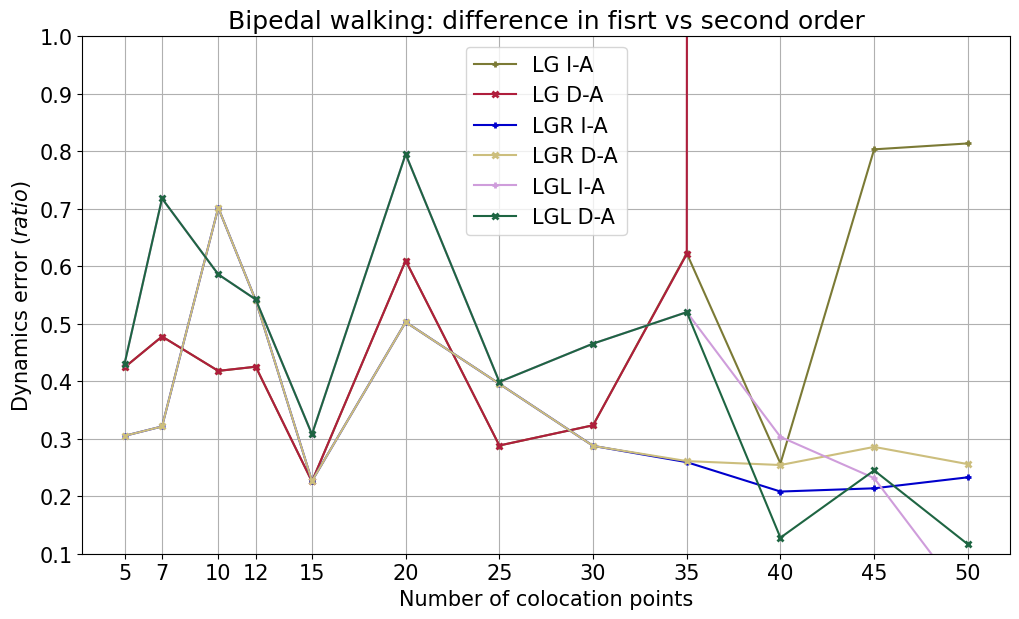

In [86]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
data_key = data_array[2]
for qq in range(1):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'Bipedal walking: difference in fisrt vs second order')#_{q_'+f'{qq+1}}}
    for scheme in schemes: #results.keys():#
        key_1 = scheme + '_1'
        key_2 = scheme + '_2'
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ms'] = markersize
        if 'TD' in scheme:
            plot_kw['marker'] = 'x'
            plot_kw['mew'] = '2'
                
        if 'BU' in scheme:
            plot_kw['marker'] = '+'
            plot_kw['mew'] = '2'
        N_arr = results[key_1]['N_arr']
        if len(results[key_1][data_key].shape) == 1:
            arr1 = results[key_1][data_key]
            arr2 = results[key_2][data_key]
            arr_coef = arr2 / arr1
            q_arr.append(arr_coef)
            plt.plot(N_arr,
            arr_coef,
            **plot_kw)
        #else:
        #    plt.plot(N_arr,
        #     results[key_1][data_key][:,qq],
        #     **plot_kw)
   # plt.yscale('log')
    ticks = np.array(results[key_1]['N_arr'])
    #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'ratio'
        
    if fixed_y_scale:
        y_lims = [1e-1, 1]
        plt.ylim(y_lims)
    
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'integ_dyn_error',
            schemes_printed = schemes,
            save_format = save_fmt,
            N = None,
            q_counter = None,
        )

In [87]:
q_arr_c = np.array(q_arr, dtype = float)

In [88]:
_aa = 0.2<q_arr_c
_bb = 0.6>q_arr_c

In [89]:
np.mean(_aa*_bb)

In [90]:
np.median(q_arr_c[:,:-4])

In [91]:
np.mean(q_arr_c[:,:-4])

In [92]:
np.std(q_arr_c[:,:-4])

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

In [93]:
# Here we print the data shown in Table II of the paper
for scheme in ['trapz_1', 'trapz_n_2', 'hs_parab_1', 'hsn_parab_2']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    line = r'\TZ{' if 'trap' in scheme else r'\HS{'
    line += scheme[-1] + r'} & ' + str(N) + r' & ' + f'{results[key][N]["cpudt"]:.2f}'+ r' & ' 
    a = results[key][N]['error']['err_q'][0]
    line += f'{a:.5f}' if a > 1e-5 else '0      '
    #line += r' & '
    #line += f'{b:.4f}' if b > 1e-5 else '0     '
    c = results[key][N]['error']['err_2'][0]
    line += r' & ' + f'{c:.5f}'.rjust(7) + r' \\'
    print(line)

\TZ{1} & 50 & 0.25 & 0.00043 & 0.09246 \\
\TZ{2} & 50 & 0.23 & 0       & 0.00208 \\
\HS{1} & 25 & 0.24 & 0.00002 & 0.00358 \\
\HS{2} & 25 & 0.25 & 0       & 0.00027 \\


## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)